#### reading material

In [439]:
# https://support.sas.com/resources/papers/proceedings/proceedings/sugi30/203-30.pdf
# https://books.google.co.il/books?id=KFAnkvqD8CgC&pg=PA61&redir_esc=y#v=onepage&q&f=false
# https://www.theanalysisfactor.com/the-fundamental-difference-between-principal-component-analysis-and-factor-analysis/
# https://www.mathworks.com/help/stats/examples/factor-analysis.html
# https://iescoders.com/exploratory-factor-analysis/
# https://nwfsc-timeseries.github.io/atsa-labs/sec-dfa-example1.html
# https://scikit-learn.org/stable/modules/decomposition.html#fa

In [760]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
from tqdm.auto import tqdm 
import matplotlib.gridspec as gridspec

import seaborn as sns

import geopandas as gp
import geoplot
import geoplot.crs as gcrs

from scipy import signal
from sklearn.decomposition import FastICA, PCA

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%config InlineBackend.figure_format = 'retina'

In [761]:
from factor_analyzer import FactorAnalyzer, ConfirmatoryFactorAnalyzer, ModelSpecificationParser
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [762]:
import warnings
warnings.filterwarnings("ignore")

# Functions

In [763]:
def scree_plot(ev,df):    
    plt.plot(range(1,df.shape[1]+1),ev,'-o',color='b')
    plt.title('Scree Plot')
    plt.xlabel('Number of factors')
    plt.ylabel('Eigenvalue')
    plt.axhline(y=1,c='r')
    plt.show();
    
    
def perform_fa(df, NUM, rotation, method):
    fa = FactorAnalyzer(n_factors=NUM, rotation=rotation, method=method) 
    fa.fit(df)
    return fa

def loadings_plot(Loadings, col_names):
    fig, ax = plt.subplots(figsize=(8,8))
    c = ax.pcolor(abs(Loadings))
    fig.colorbar(c, ax=ax)
    ax.set_yticks(np.arange(Loadings.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(Loadings.shape[1])+0.5, minor=False)
    ax.set_yticklabels(col_names)
    ax.set_xticklabels(['Factor '+str(i+1) for i in range(Loadings.shape[1])])
    # plt.savefig("/home/idit/Documents/saved_data_from_notebooks/loadings_4_factors.png", dpi=500)
    plt.show();   
    
def plot_map(gdf,stations): 
    plt.ion
    # change the Coordinate Reference System (CRS)
    gdf['geometry']=gdf['geometry'].to_crs({'init':'epsg:4326'})
    df = gp.GeoDataFrame(stations, crs = {'init':'epsg:4326'}, geometry = gp.points_from_xy(stations['Lon'],stations['Lat'])) #where df is your df with the scatter data
    ax = gdf.plot(figsize=(10, 10),color='w',edgecolor='k')
    df.plot(ax=ax,c=stations['factor'])
    # plt.savefig("/home/idit/Documents/saved_data_from_notebooks/map_4_factors.png", dpi=500)
    for k, v in df.iterrows():
#         ax.annotate(np.round(v.max_load,2),(v.Lon,v.Lat),size=6)
        ax.annotate(v.name,(v.Lon,v.Lat),size=6)
    plt.show();
    
      
def plot_factors_and_loadings(df_scores,df_load,list_of_factors, station_names):
    mpl.style.use('seaborn-white')
#     cm = ['c','m','#d9534f','#9ad801']
    cm = sns.color_palette(None, len(list_of_factors))
    
    # https://nextjournal.com/bebi5009/matplotlib-tutorial
    fig = plt.figure(figsize=(12,11))
    grid = plt.GridSpec(3, 4)  # 2 rows 3 cols
    ax1 = plt.subplot(grid[0,:3])  # top left
    df_scores.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=False)
    # ax1.legend(loc='upper right')
    plt.xlim([-1,368])
    plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
    plt.xlabel('\nDay in the year')

    ax2 = plt.subplot(grid[1,:3])   # middle left
    df_scores.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=False)
    plt.xlim([-1,48*7+1])
    plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))
    plt.xlabel('\nHour in the week')


    ax3 = plt.subplot(grid[2,:3])  # bottom left
    df_scores.groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=False)
    plt.xlim([0,47])
    plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
    plt.xlabel('\nHour in the day')


    ax4 = plt.subplot(grid[0:3,3:5])  # all right

    df_load[list_of_factors].plot(kind='barh', stacked=True, color=cm,ax=ax4,legend=False)
    ax4.legend(bbox_to_anchor=(1.53, 1), loc=2 ,frameon=True)
    ax4.set_yticks(np.arange(0,34))
    ax4.set_yticklabels(station_names)
    ax4.yaxis.tick_right()
    ax4.set_facecolor('white')
    plt.xlabel('\nLoadings')
    # plt.show();

    fig.tight_layout()
    plt.show();
    
    
def test_if_FA_suitable(df):
    
    # Bartlett’s Test - p-value should be significant
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    # Kaiser-Meyer-Olkin (KMO) Test - between 0 and 1 - when 1 is highly suitable for factor analysis
    kmo_all,kmo_model=calculate_kmo(df)
    return p_value, kmo_model
    
    
def add_group_columns_to_df_scores(df_scores,times):
    df_scores['datetime'] = pd.to_datetime(times['time'], format='%Y-%m-%d %H:%M')
    df_scores['week day'] = pd.to_datetime(times['time']).dt.dayofweek+1
    df_scores['month'] = pd.to_datetime(times['time']).dt.month
    df_scores['hour'] = pd.to_datetime(times['time']).dt.hour
    df_scores['minute'] = pd.to_datetime(times['time']).dt.minute
    df_scores['Day in year'] = pd.to_datetime(times['time']).dt.dayofyear

    df_scores.loc[df_scores['week day']==7,'week day']=0
    
    return df_scores

def plot_time_series_sections(df,list_of_factors,times):
    
    df = add_group_columns_to_df_scores(df,times)
    cm = sns.color_palette(None, len(list_of_factors))
    
    mpl.style.use('seaborn-white')
    # https://nextjournal.com/bebi5009/matplotlib-tutorial
    fig = plt.figure(figsize=(12,11))
    grid = plt.GridSpec(3, 1)  # 2 rows 3 cols
    ax1 = plt.subplot(grid[0,:1])  # top left
    df.groupby(['Day in year'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax1,legend=False)
    # ax1.legend(loc='upper right')
    plt.xlim([-1,368])
    plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
    plt.xlabel('\nDay in the year')
    ax1.legend(bbox_to_anchor=(1.1, 1), loc=2 ,frameon=True)

    ax2 = plt.subplot(grid[1,:1])   # middle left
    df.groupby(['week day','hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax2,legend=False)
    plt.xlim([-1,48*7+1])
    plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))
    plt.xlabel('\nHour in the week')


    ax3 = plt.subplot(grid[2,:1])  # bottom left
    df.groupby(['hour','minute'])[list_of_factors].mean().plot(style='.-',color=cm,ax=ax3,legend=False)
    plt.xlim([0,47])
    plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
    plt.xlabel('\nHour in the day')
    

    fig.tight_layout()
    plt.show();

# FA - all stations

##### load data

In [764]:
df = pd.read_csv("~/Documents/saved_data_from_notebooks/RF_add1.csv")
times = pd.read_csv("~/Documents/saved_data_from_notebooks/times_df.csv")
times.drop(columns = 'Unnamed: 0',inplace=True)

In [765]:
df.head()
df.shape

,AFULA,ANTOKOLSKY,HOLON,IRONID,KVISH4,REMEZ,YAD_LEBANIM,YEFET_YAFO,AHUZA_G,ATZMAUT_B,...,ORT,ROVA_TV,SDEROT,SDE_YOAV,YAHALOM,BEER_SHEVA,EAST_NEGEV,KFAR_MASARIK,PARDES_HANA,RAANANA
0,27.45,28.10,55.0,43.80,34.80,35.67,23.76,32.27,17.8,31.2,...,39.2,39.2,45.7,35.1,52.40,35.3,13.83,9.3,16.9,29.40
1,24.02,26.67,55.0,43.76,35.00,43.40,18.50,26.19,17.8,38.8,...,49.0,49.0,54.0,34.4,42.40,33.1,19.95,15.6,16.9,26.73
2,29.18,27.70,55.0,46.38,43.72,45.86,21.70,34.96,16.2,43.3,...,43.8,43.8,48.0,44.9,42.67,25.9,28.39,20.2,11.9,38.69
3,19.40,26.30,64.6,48.70,44.01,40.65,23.60,37.76,17.1,39.3,...,39.4,39.4,25.6,34.6,45.40,26.4,21.93,16.6,15.1,35.50
4,25.70,28.00,71.0,44.70,32.94,28.13,25.00,27.66,18.3,37.1,...,42.5,42.5,20.3,26.0,35.10,34.6,21.65,14.4,17.0,33.81


(105166, 34)

##### add time 

In [766]:
# times.head()
# times.shape
# times.rename({'0': 'time'}, axis = 'columns',inplace=True)

# df.set_index(times['time'],drop=True,inplace=True)
# df.index = pd.to_datetime(df.index,format='%Y-%m-%d %H:%M')

# df.head()

# # try taking the maximal/mean daily value
# df = df.resample('1D').mean()

##### perform tests to see data is suitable for FA

In [767]:
test_if_FA_suitable(df)
#p_value should be significant and second output as close to 1 as possible

(0.0, 0.9864025974424117)

##### FA model

In [768]:
# sorted(mpl.style.available)
mpl.style.use('default')

In [769]:
# if to enable zooming
# %matplotlib notebook

FactorAnalyzer(rotation_kwargs={})

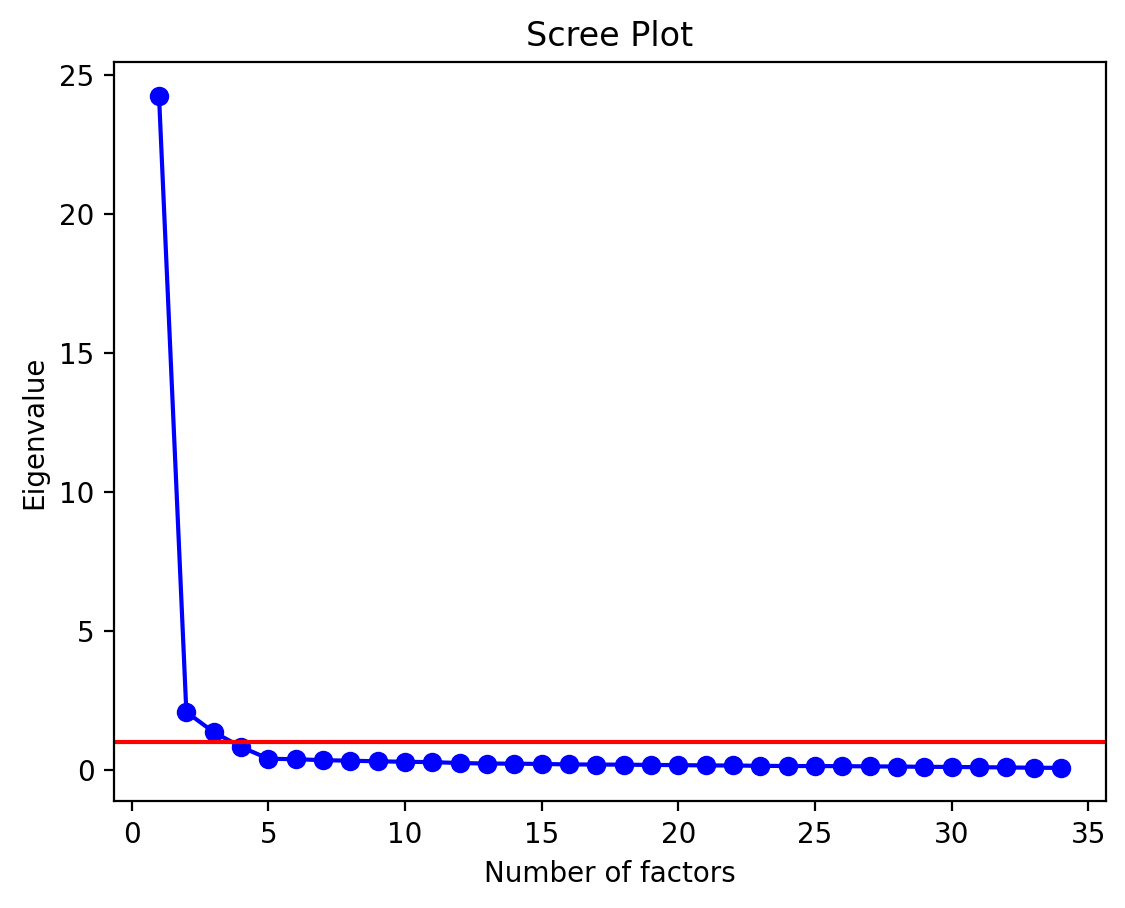

In [776]:
# Check Eigenvalues
fa = FactorAnalyzer()
fa.fit(df)
ev, _ = fa.get_eigenvalues()
scree_plot(ev,df)

In [777]:
NUM = 4
rotation = 'promax' #oblimin - seperates perfectly by geographical region, quartimin, promax, varimax

In [778]:
# perform factor analysis, method = 'minres' (default), 'ml', 'principal'. minres finds the minimum residuals solution.
fa = perform_fa(df, NUM, rotation, method = 'ml')
# Principal Axis Factor is recommended when the data violate the assumption of multivariate normality (Costello & Osborne, 2005).

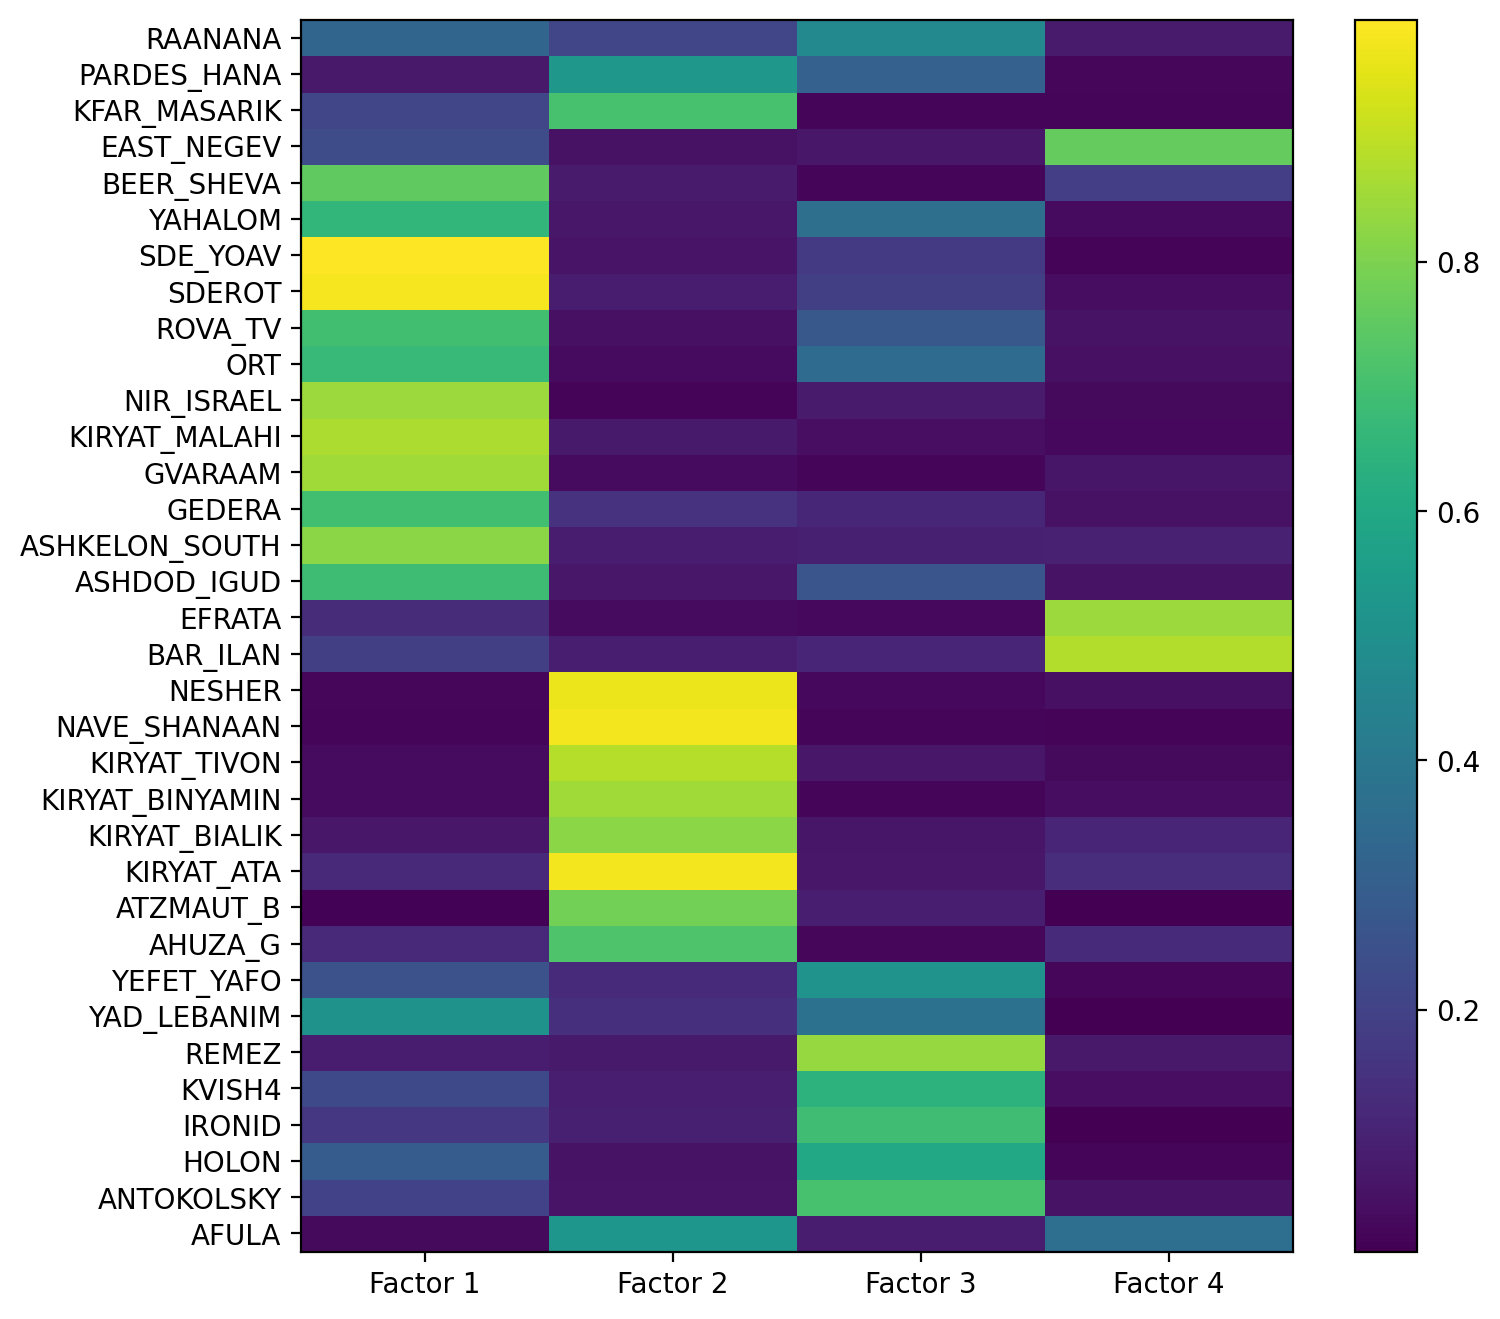

In [779]:
Loadings = fa.loadings_
col_names = df.columns
loadings_plot(Loadings, col_names)

In [780]:
# which stations are Trans/traffic? IRONID,KVISH4,REMEZ,YEFET_YAFO,ATZMAUT,BAR_ILAN,RAANANA. 

In [781]:
# plot on a map to see stations more associated with certain factors
stations = pd.read_csv("~/Documents/saved_data_from_notebooks/stations_info.csv") 

In [782]:
# ascribe a factor to each station based on max loading value (and show it on map)

In [783]:
stations['factor'] = np.argmax(abs(Loadings),axis=1)+1
stations['max_load'] = np.max(abs(Loadings),axis=1)

In [784]:
stations

,name,type,X,Y,Lon,Lat,HASL,HAGL,factor,max_load
0,AFULA,Gener,227646,723263,35.290982,32.603289,53.0,16.000000,2,0.524585
1,ANTOKOLSKY,Gener,179676,665772,34.781938,32.083413,23.8,12.000000,3,0.704872
2,HOLON,Gener,178260,658402,34.767689,32.017671,17.0,15.800000,3,0.600455
3,IRONID,Trans,180414,666788,34.790148,32.093370,10.0,3.800000,3,0.691581
4,KVISH4,Trans,185207,664177,34.841016,32.069980,47.0,3.800000,3,0.641260
5,REMEZ,Trans,183802,666558,34.826045,32.091480,19.0,3.800000,3,0.839605
6,YAD_LEBANIM,Gener,183259,664871,34.820641,32.076766,56.0,17.799999,1,0.505778
7,YEFET_YAFO,Trans,176798,661903,34.752061,32.049187,19.0,3.800000,3,0.513903
8,AHUZA_G,Gener,199059,743556,34.985998,32.786114,274.0,15.300000,2,0.717190
9,ATZMAUT_B,Trans,200549,746930,35.001834,32.816567,13.0,3.800000,2,0.782570


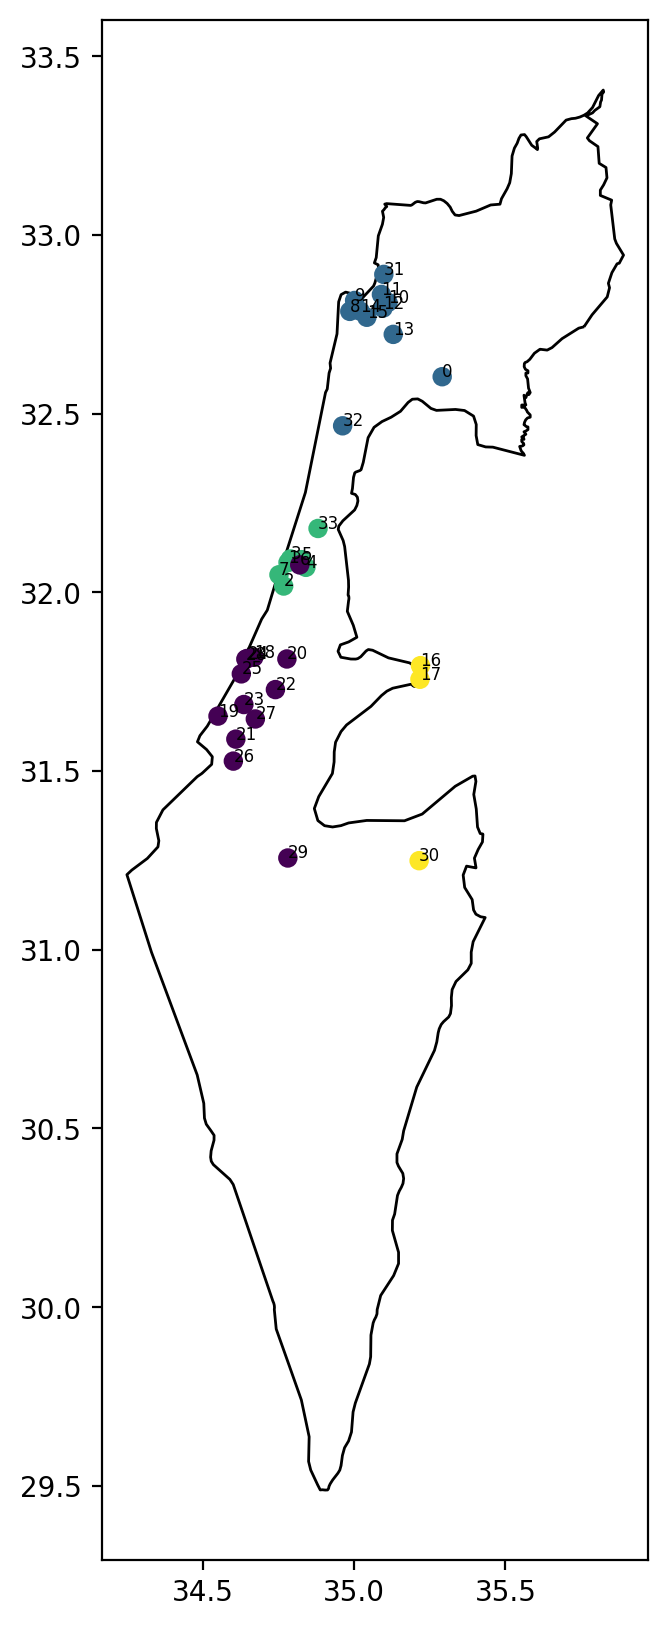

In [785]:
gdf = gp.read_file("/home/idit/Documents/saved_data_from_notebooks/IsraelBorder.shp")
plot_map(gdf,stations)
# as far as I understand the numbers display the value of cummunality - how much that ascribed factor explain out of 
# the variance of the station (0-1). 

we can see that the common variance is mainly related to geographical areas. It is a proof that PM2.5 is highly related to meteorological conditions. 

Common variance is the amount of variance that is shared among a set of features (stations). stations that are highly correlated will share a lot of variance.

### understanding variance explained 

Communality (also called $h^2$) is a definition of common variance that ranges between 0 and 1. Values closer to 1 suggest that extracted factors explain more of the variance of an individual station.
Unique variance is any portion of variance that’s not common and it equals Specific variance (specific per station) + Error variance (anything unexplained by common or specific variance)

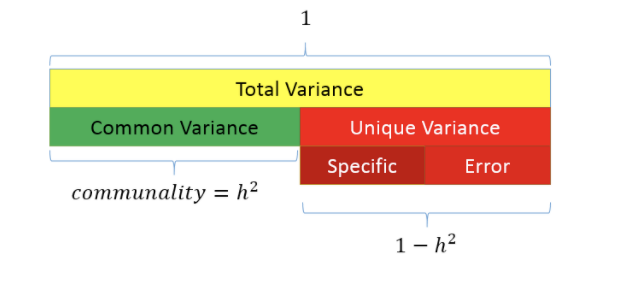

In [786]:
# 1. Sum of squared loadings (variance)
# 2. Proportional variance
# 3. Cumulative variance
fa.get_factor_variance()

(array([8.54188271, 7.40319025, 3.71073087, 2.32562625]),
 array([0.25123184, 0.21774089, 0.10913914, 0.06840077]),
 array([0.25123184, 0.46897273, 0.57811188, 0.64651265]))

In [787]:
# common variance (=Sum of squared loadings)
np.sum(Loadings**2,axis=0)

array([8.54188271, 7.40319025, 3.71073087, 2.32562625])

In [788]:
# mean loadings of each factor (=proportional variance)
np.mean(Loadings**2,axis=0)

array([0.25123184, 0.21774089, 0.10913914, 0.06840077])

In [789]:
# mean explained total variance (=Cumulative variance)
np.cumsum(np.mean(Loadings**2,axis=0))

array([0.25123184, 0.46897273, 0.57811188, 0.64651265])

In [790]:
# this should equal the communalities. We might want to remove stations that
# not enough variance is accounted for by the chosen factors (=low communalities)
# "A particular set of factors is said to explain a lot of the variance of a variable if it has a high communality"
# "Often times variables with low communalities (less than .20 so that 80% is unique variance) are eliminated from the analysis since the aim of factor analysis is to try and explain the variance through the common factors"
fa.get_communalities()
np.sum(Loadings**2,axis=1)

array([0.4120163 , 0.54288573, 0.44772742, 0.51412859, 0.47071065,
       0.72255208, 0.4163052 , 0.34559554, 0.54487092, 0.6207461 ,
       0.9929462 , 0.6969371 , 0.73007548, 0.79064335, 0.95514661,
       0.93491473, 0.82938887, 0.73322053, 0.54902786, 0.70480703,
       0.51783541, 0.73056674, 0.76703208, 0.7247665 , 0.57312604,
       0.56111259, 1.00340918, 1.02361141, 0.56740214, 0.6082457 ,
       0.63998344, 0.54796981, 0.38555142, 0.37617134])

array([0.4120163 , 0.54288573, 0.44772742, 0.51412859, 0.47071065,
       0.72255208, 0.4163052 , 0.34559554, 0.54487092, 0.6207461 ,
       0.9929462 , 0.6969371 , 0.73007548, 0.79064335, 0.95514661,
       0.93491473, 0.82938887, 0.73322053, 0.54902786, 0.70480703,
       0.51783541, 0.73056674, 0.76703208, 0.7247665 , 0.57312604,
       0.56111259, 1.00340918, 1.02361141, 0.56740214, 0.6082457 ,
       0.63998344, 0.54796981, 0.38555142, 0.37617134])

In [791]:
# unique variance
1 - np.sum(Loadings**2,axis=1) 
fa.get_uniquenesses()

array([ 0.5879837 ,  0.45711427,  0.55227258,  0.48587141,  0.52928935,
        0.27744792,  0.5836948 ,  0.65440446,  0.45512908,  0.3792539 ,
        0.0070538 ,  0.3030629 ,  0.26992452,  0.20935665,  0.04485339,
        0.06508527,  0.17061113,  0.26677947,  0.45097214,  0.29519297,
        0.48216459,  0.26943326,  0.23296792,  0.2752335 ,  0.42687396,
        0.43888741, -0.00340918, -0.02361141,  0.43259786,  0.3917543 ,
        0.36001656,  0.45203019,  0.61444858,  0.62382866])

array([ 0.5879837 ,  0.45711427,  0.55227258,  0.48587141,  0.52928935,
        0.27744792,  0.5836948 ,  0.65440446,  0.45512908,  0.3792539 ,
        0.0070538 ,  0.3030629 ,  0.26992452,  0.20935665,  0.04485339,
        0.06508527,  0.17061113,  0.26677947,  0.45097214,  0.29519297,
        0.48216459,  0.26943326,  0.23296792,  0.2752335 ,  0.42687396,
        0.43888741, -0.00340918, -0.02361141,  0.43259786,  0.3917543 ,
        0.36001656,  0.45203019,  0.61444858,  0.62382866])

In [792]:
# identify cross-loadings (A crossloading is when an item loads at .32 or higher on two or more factors (Costello & Osborne, 2005))
stations.loc[np.sum(Loadings>0.32,axis=1)>1,'name']

0           AFULA
6     YAD_LEBANIM
24            ORT
28        YAHALOM
33        RAANANA
Name: name, dtype: object

In [793]:
# according to matlab: 
# cov(x)=ΛΛ.T+Ψ 
# psi = np.cov(df.values) - np.dot(Loadings,Loadings.T) #it destroys the kernel

In [794]:
normalized_df=(df-df.mean())/df.std()

In [795]:
arr = normalized_df.values
cov_mat = np.dot(arr.T, arr) # how to rotate?

In [796]:
cov_mat - np.dot(Loadings,Loadings.T)

array([[105164.58798369,  75934.45160921,  72263.0483002 , ...,
         80892.1499239 ,  77891.5437672 ,  72772.61376962],
       [ 75934.45160921, 105164.45711427,  90312.23118457, ...,
         76845.73424609,  81208.33632013,  85269.31234805],
       [ 72263.0483002 ,  90312.23118457, 105164.55227258, ...,
         73684.72154442,  76909.81023391,  83802.77616089],
       ...,
       [ 80892.1499239 ,  76845.73424609,  73684.72154442, ...,
        105164.45203022,  76387.93678689,  75783.22682003],
       [ 77891.5437672 ,  81208.33632013,  76909.81023391, ...,
         76387.93678689, 105164.61444859,  80561.79216547],
       [ 72772.61376962,  85269.31234805,  83802.77616089, ...,
         75783.22682003,  80561.79216547, 105164.62382866]])

### bar-plot of loadings

In [797]:
df_load = pd.DataFrame(Loadings,columns=['F1','F2','F3','F4'])

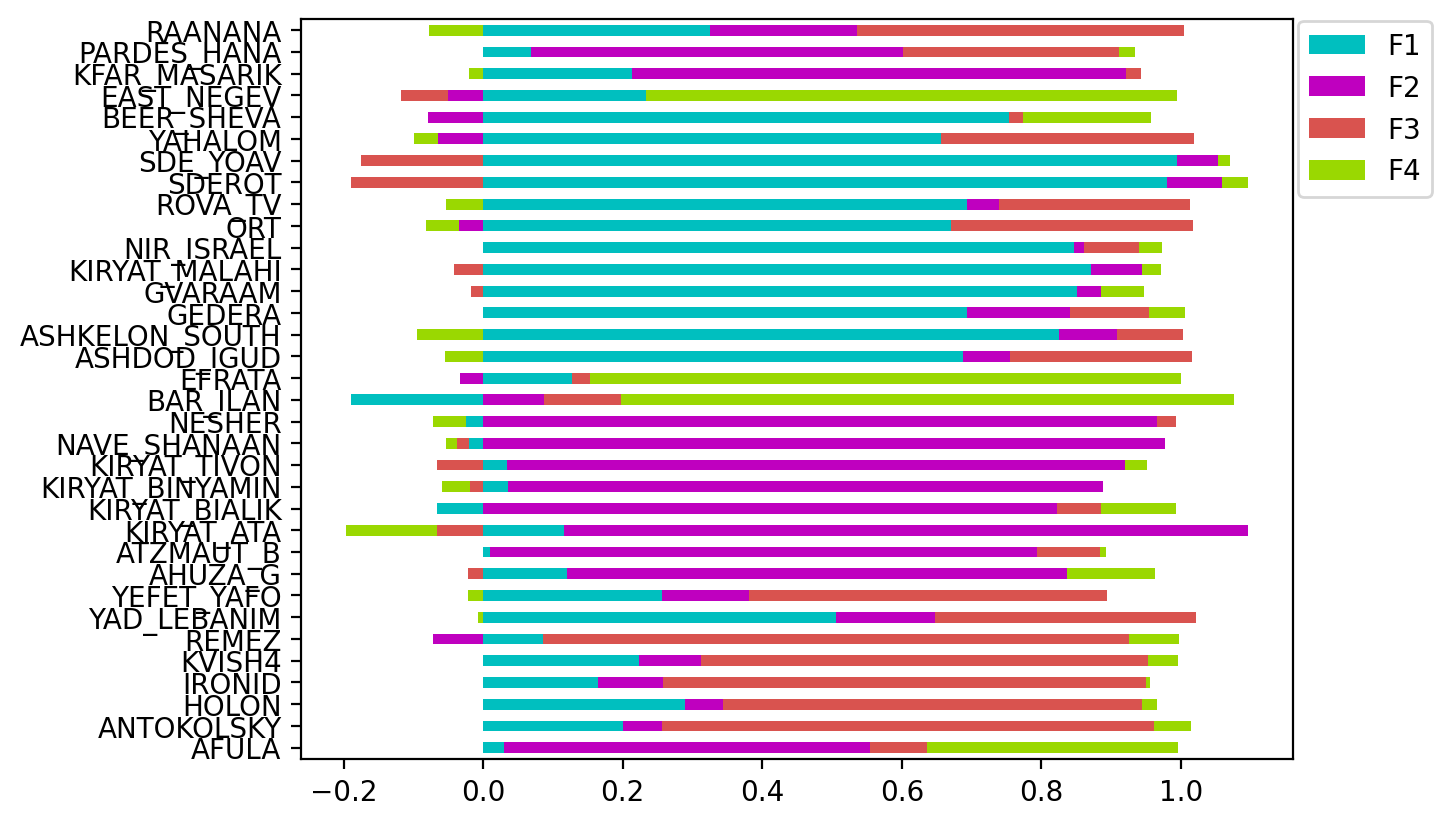

In [798]:
ax = df_load.plot(kind='barh', stacked=True, color=['c','m','#d9534f','#9ad801'])
ax.legend(loc=[1.005,0.76])
ax.set_yticks(np.arange(0,34))
ax.set_yticklabels(df.columns)
ax.set_facecolor('white')
plt.show();

In [799]:
"if the factors are correlated (oblique), the factor loadings are regression coefficients and not correlations and as such they can be larger than one in magnitude"

'if the factors are correlated (oblique), the factor loadings are regression coefficients and not correlations and as such they can be larger than one in magnitude'

### reconstract a signal due to one of the factors. 

In [800]:
Rotations = fa.rotation_matrix_

In [801]:
Rotations

array([[ 0.4634088 ,  0.32082831, -0.07459941, -0.24375288],
       [-1.13356381,  1.51062012, -0.06657983,  0.36707816],
       [-0.00385579,  0.41200029,  1.28863651, -0.63420394],
       [ 1.4273663 ,  0.59315145,  0.53810707,  1.65611874]])

In [802]:
factors = np.dot(df,Loadings)

In [803]:
factors

array([[483.60998309, 185.99969154, 231.57714422,  67.08341021],
       [510.670666  , 201.94663261, 232.74062622,  75.2714438 ],
       [550.40704083, 223.23802152, 268.07287711,  72.17192041],
       ...,
       [212.8954056 , 260.53490778, 170.39877085,  53.68932606],
       [266.56831128, 262.0563364 , 170.64423744,  49.2091306 ],
       [303.79783628, 266.26746515, 194.76974288,  42.33512213]])

In [804]:
scores = fa.transform(df) # numerical value, no units

# factor loadings  = the weight of each factor on the observed variables
# factor scores = the weights of each observed variable in producing a score representing the factor

In [805]:
scores.shape

(105166, 4)

### Look at daily/weekly/monthly patterns of the factors 

In [806]:
times.rename({'0': 'time'}, axis = 'columns',inplace=True)
# df_scores.set_index(times['time'],drop=True,inplace=True)
# df_scores.index = pd.to_datetime(df_scores.index,format='%Y-%m-%d %H:%M')
# df_scores.head()

In [807]:
df_scores = pd.DataFrame(scores, columns=['F1','F2','F3','F4'])

In [808]:
# # correlation between scores?
# from pandas.plotting import scatter_matrix
# scatter_matrix(df_scores, alpha=0.2, figsize=(6, 6), diagonal='kde')
# plt.show();

In [809]:
df_scores = add_group_columns_to_df_scores(df_scores,times)

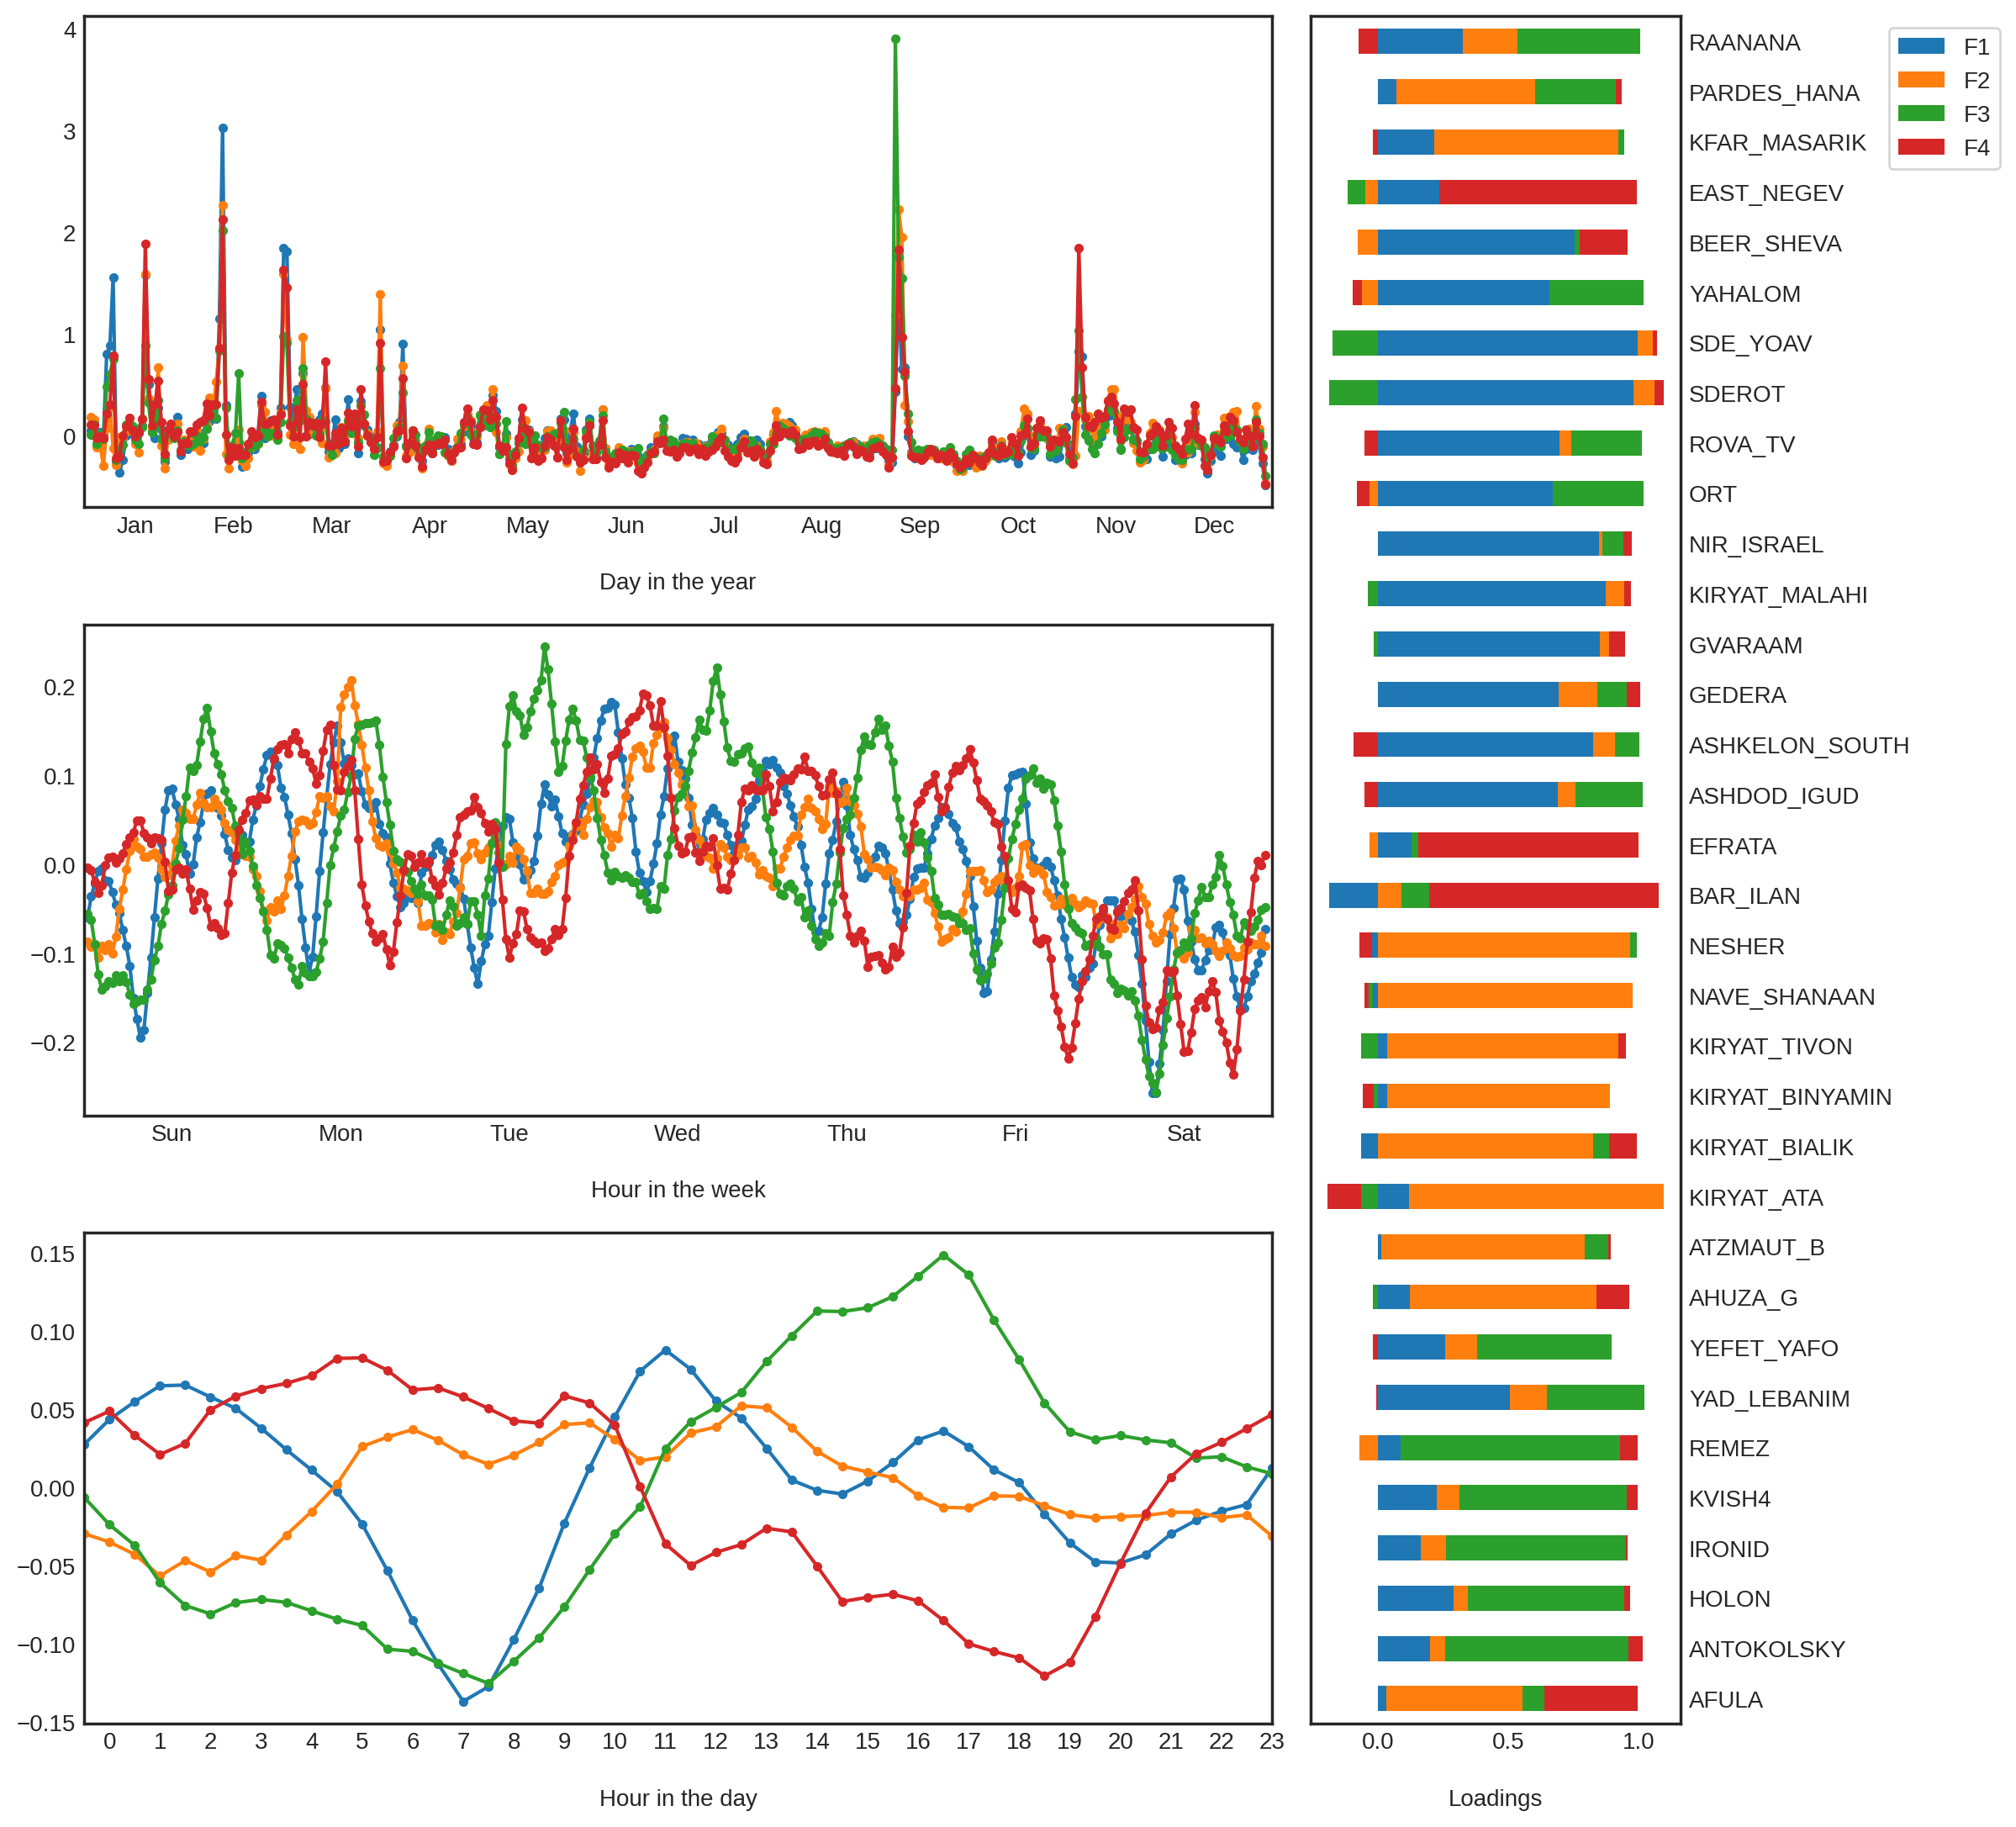

In [810]:
list_of_factors = ['F1','F2','F3','F4']
plot_factors_and_loadings(df_scores,df_load,list_of_factors, df.columns)

In [ ]:
# Blue = transportation? why high at night?, Orange = industry, Red = opposite to temperature?, green = mega-city, gush dan? temperature?

In [ ]:
# ARE THE FACTOR SCORES ALREADY B*X or just the B?

In [436]:
# Eventually, I would want to calculate the X concentrations related to factor 1, the X concentrations related to factor 2 etc..
# I'm not sure how to fix the units and what to do with the error
X1 = np.dot(scores[:,0].reshape(-1,1),Loadings[:,0].reshape(1,-1)) #plus unique variance?

In [437]:
# X1 = X1*df.std()+df.mean() #? this is for all concentrations... can't be right. maybe de-standerdizing the loadings.
X1.shape

(105166, 34)

### Try FA per geographical area 

In [811]:
# South (factor-1)
df_south = df[stations.loc[stations.factor==1,'name']]
df_south.drop('BEER_SHEVA',axis=1, inplace=True)
# North (factor-2)
df_north = df[stations.loc[stations.factor==2,'name']]
# Center (factor-3)
df_center = df[stations.loc[stations.factor==3,'name']]
# East (factor-4)
df_east = df[stations.loc[stations.factor==4,'name']]

In [812]:
df_south.head()
# df_north.head()
# df_center.head()
# df_east.head()

,YAD_LEBANIM,ASHDOD_IGUD,ASHKELON_SOUTH,GEDERA,GVARAAM,KIRYAT_MALAHI,NIR_ISRAEL,ORT,ROVA_TV,SDEROT,SDE_YOAV,YAHALOM
0,23.76,29.00,37.20,40.5,61.7,35.4,57.6,39.2,39.2,45.7,35.1,52.40
1,18.50,32.27,36.84,35.9,64.4,44.6,65.4,49.0,49.0,54.0,34.4,42.40
2,21.70,105.94,38.29,35.7,56.2,35.6,62.0,43.8,43.8,48.0,44.9,42.67
3,23.60,90.80,40.63,29.4,43.8,30.0,55.4,39.4,39.4,25.6,34.6,45.40
4,25.00,57.20,34.50,26.5,24.9,27.0,42.2,42.5,42.5,20.3,26.0,35.10


In [813]:
test_if_FA_suitable(df_south)
test_if_FA_suitable(df_north)
test_if_FA_suitable(df_center)
test_if_FA_suitable(df_east)

(0.0, 0.9738031636177638)

(0.0, 0.9691932642187779)

(0.0, 0.9484017277816936)

(0.0, 0.7269222270855443)

### South

FactorAnalyzer(rotation_kwargs={})

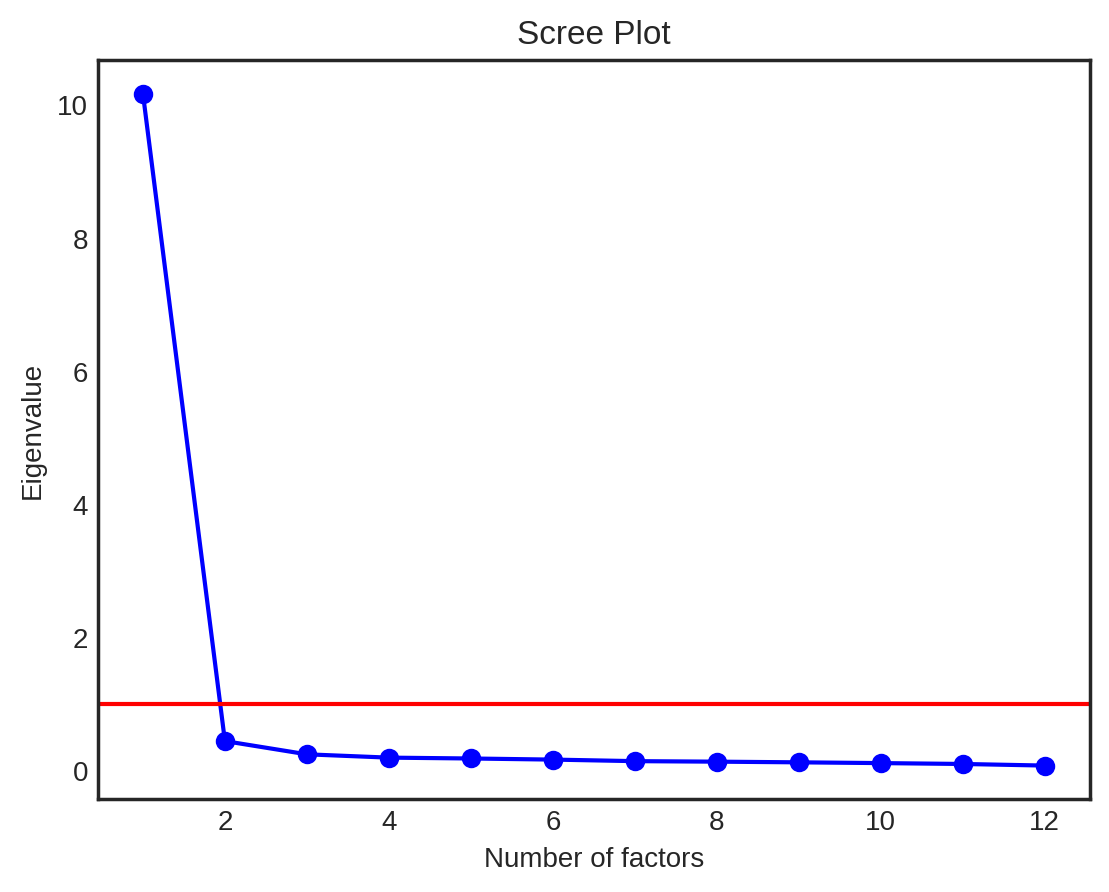

In [814]:
# Check Eigenvalues
fa = FactorAnalyzer()
fa.fit(df_south)
ev, _ = fa.get_eigenvalues()
scree_plot(ev,df_south)

In [815]:
NUM = 2
rotation = 'promax' #oblimin, quartimin, promax, varimax

In [816]:
# perform factor analysis, method = 'minres' (default), 'ml', 'principal'. minres finds the minimum residuals solution.
fa = perform_fa(df_south, NUM, rotation, method = 'ml')
# Principal Axis Factor is recommended when the data violate the assumption of multivariate normality (Costello & Osborne, 2005).

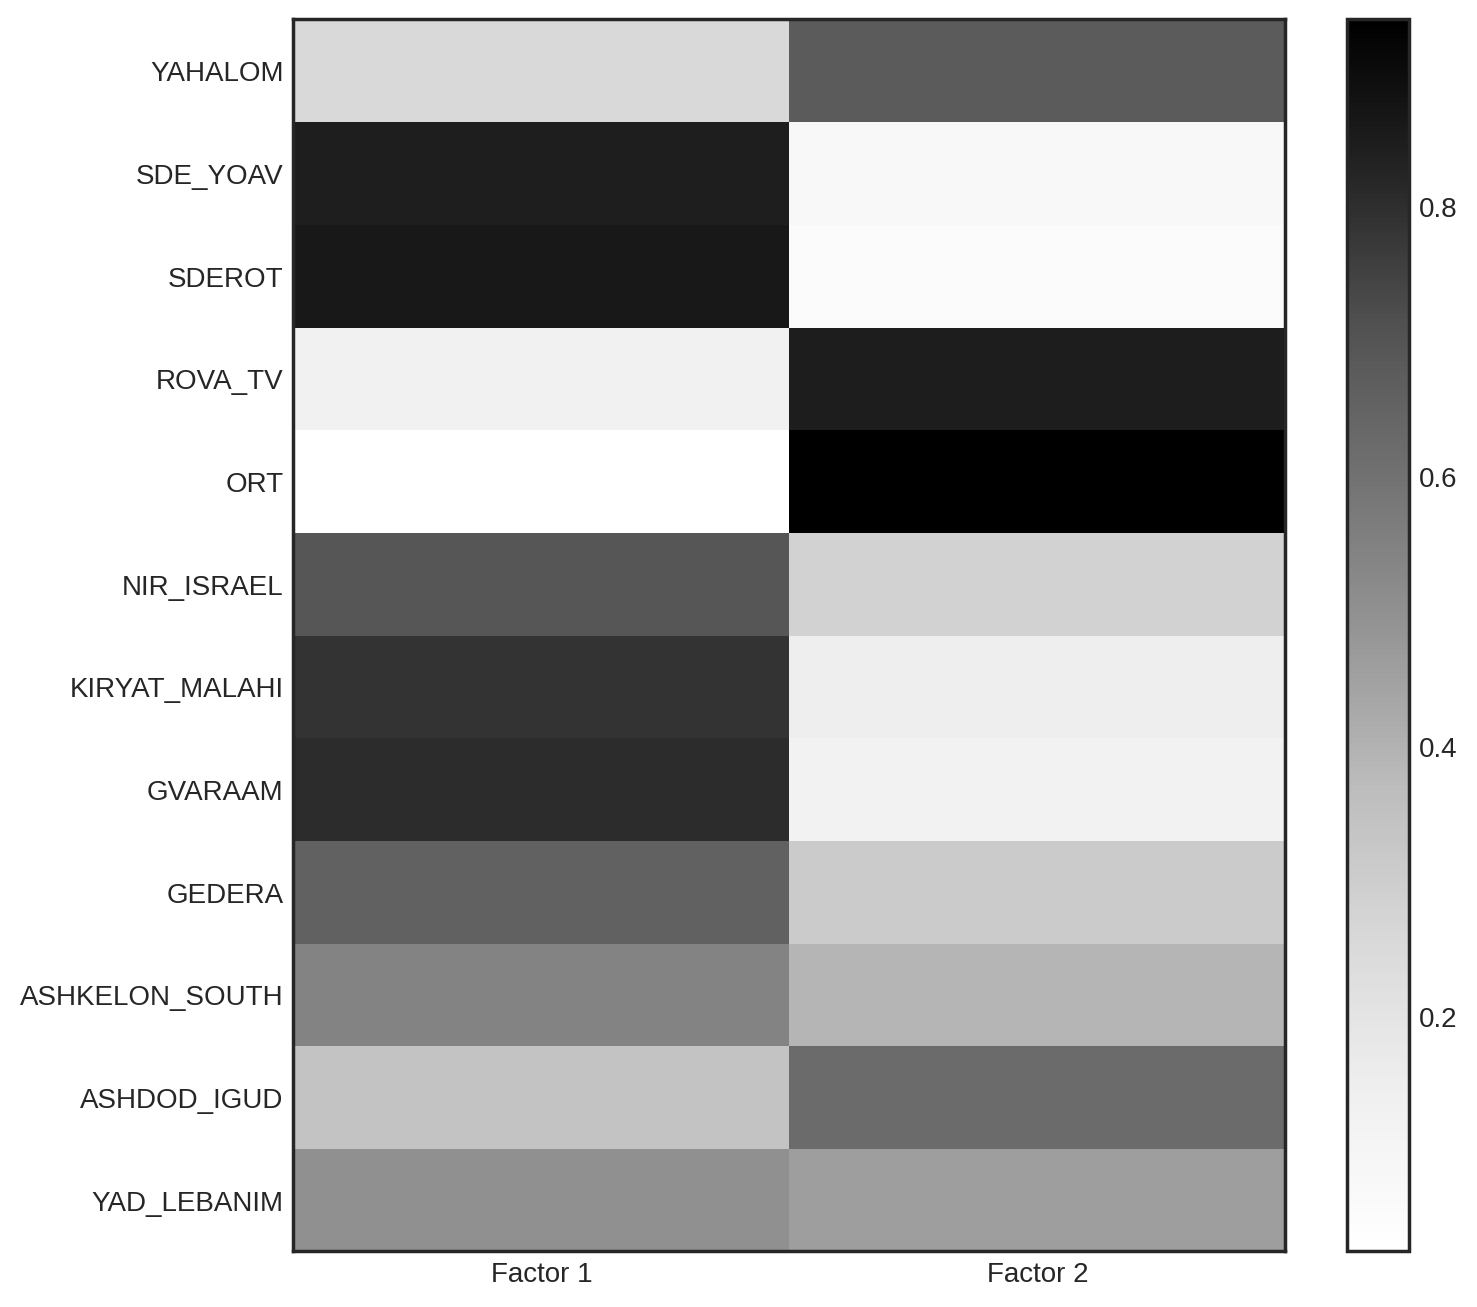

In [817]:
Loadings = fa.loadings_
col_names = df_south.columns
loadings_plot(Loadings, col_names)
# which stations are Trans/traffic? IRONID,KVISH4,REMEZ,YEFET_YAFO,ATZMAUT,BAR_ILAN,RAANANA. 

In [818]:
df_load = pd.DataFrame(Loadings,columns=['F1','F2'])
df_scores = pd.DataFrame(fa.transform(df_south), columns=['F1','F2'])

df_scores = add_group_columns_to_df_scores(df_scores,times)

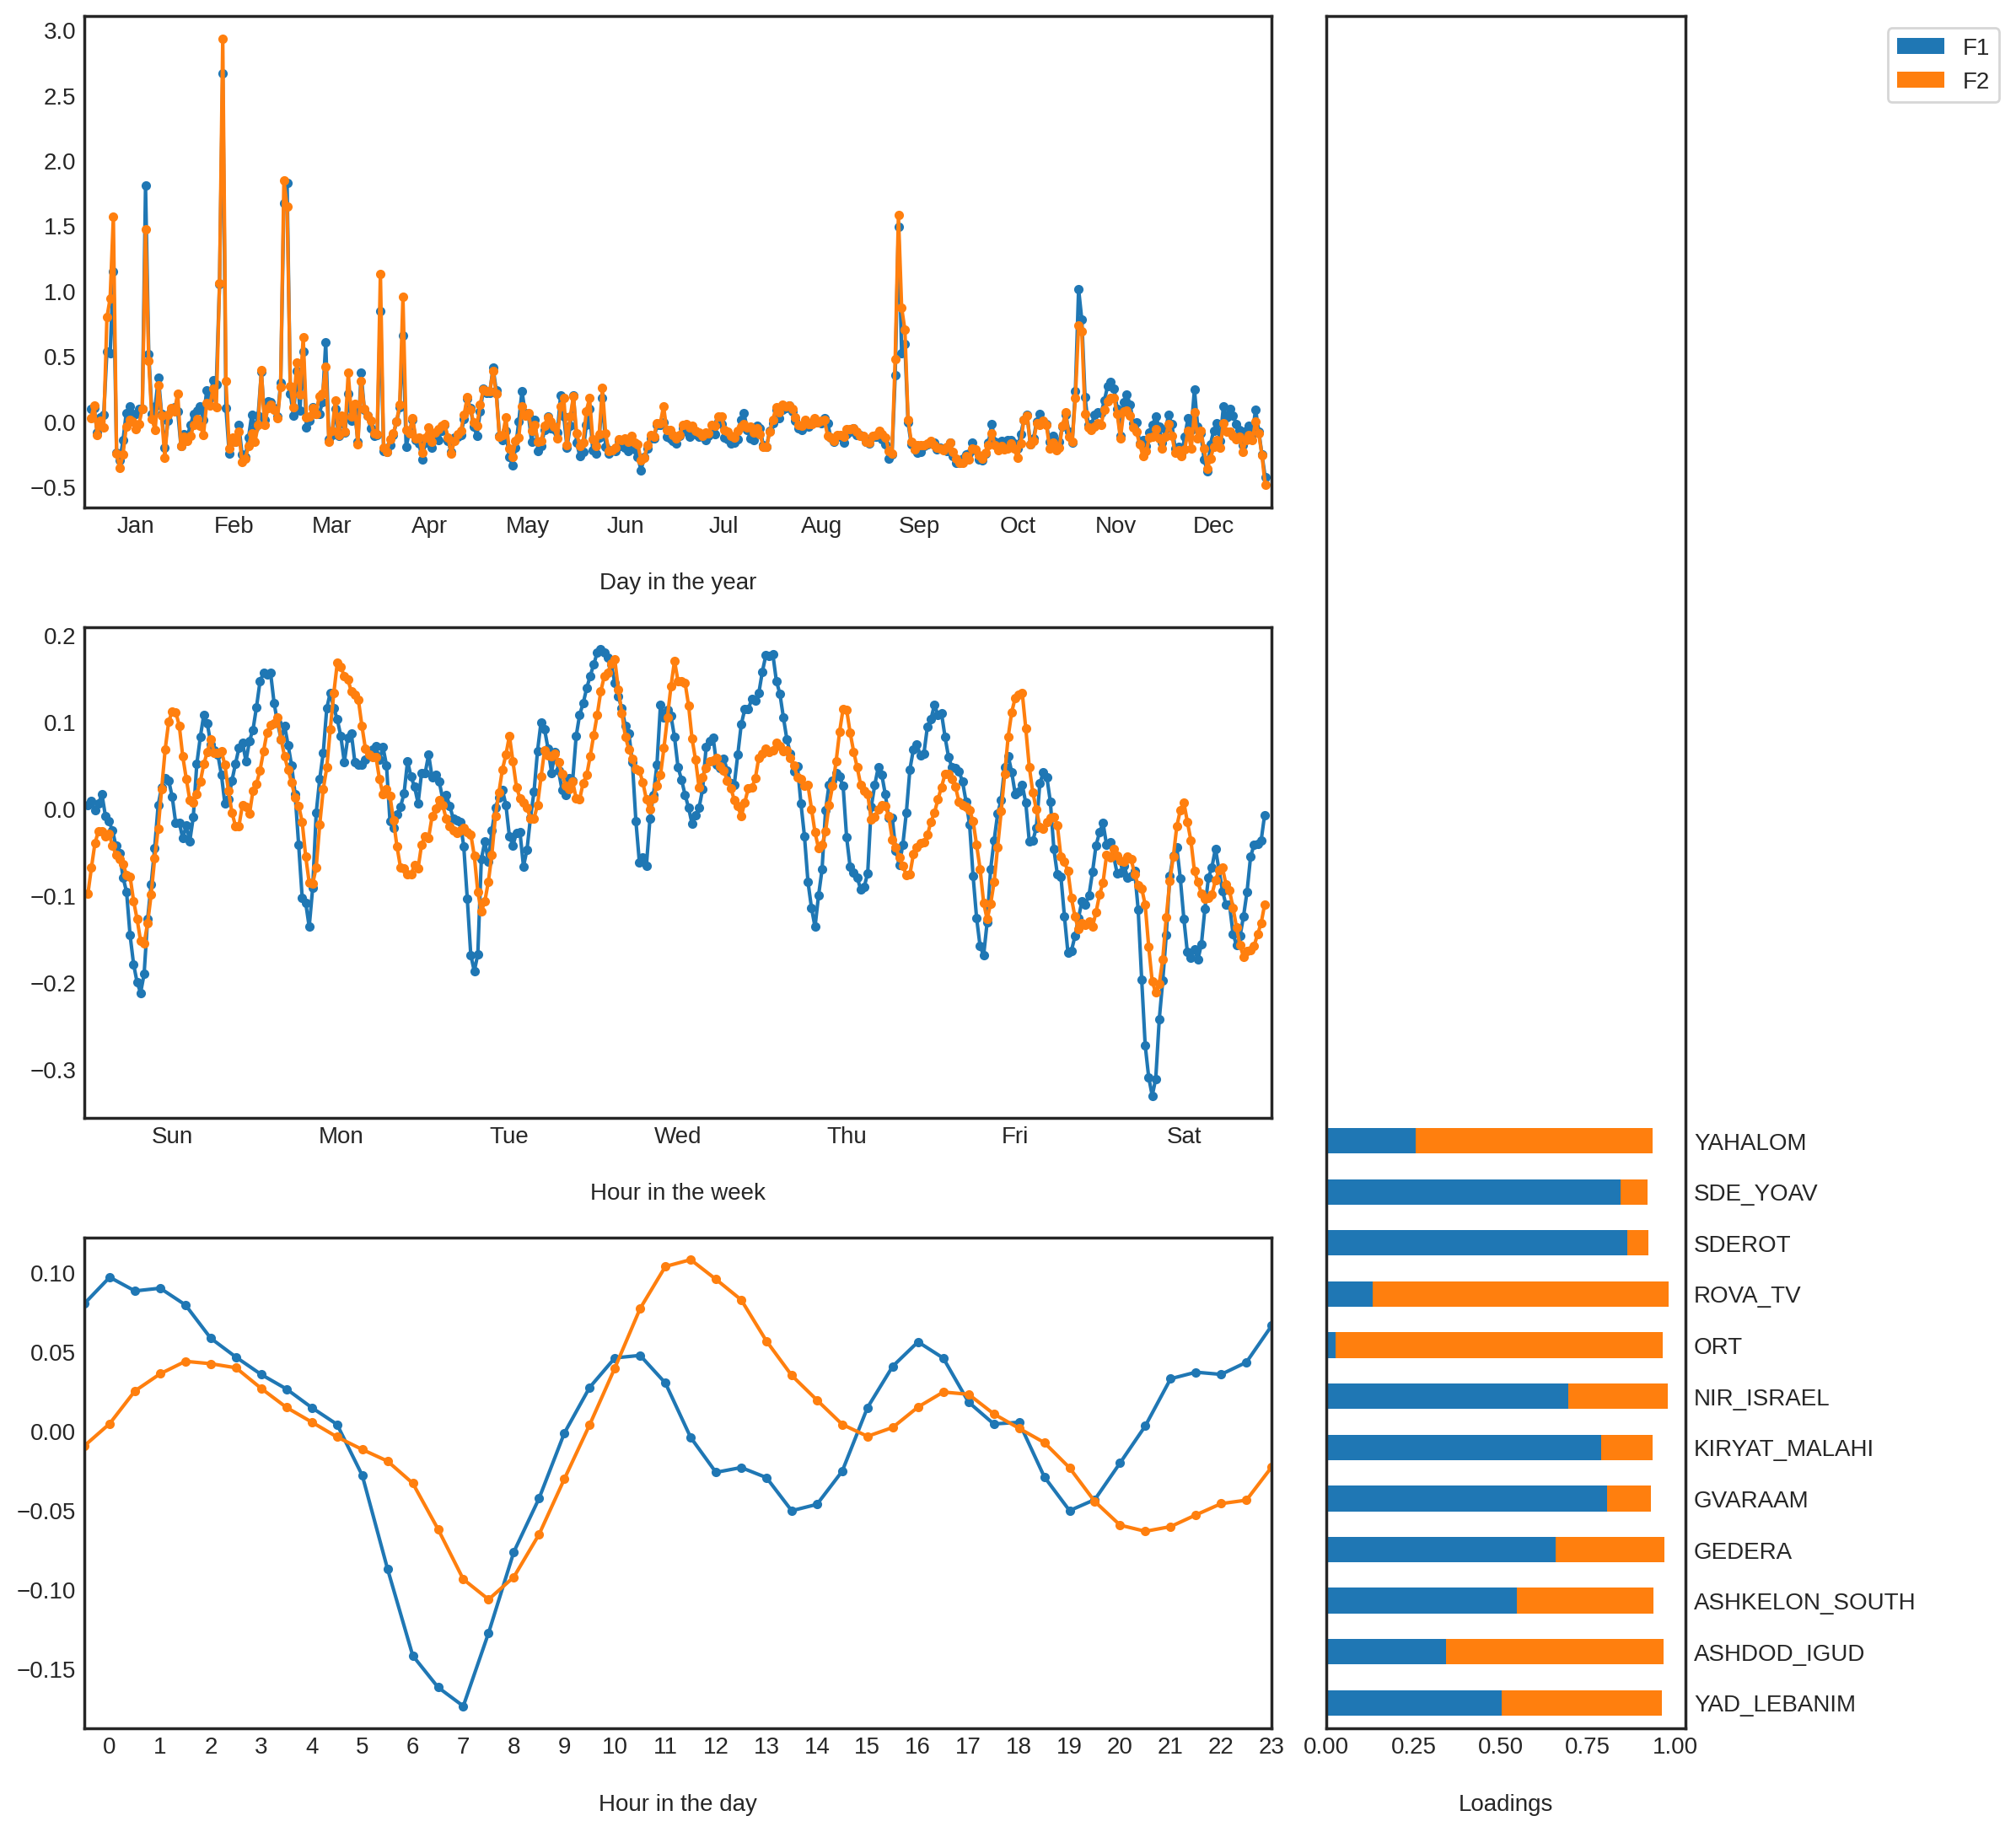

In [819]:
list_of_factors = ['F1','F2']
plot_factors_and_loadings(df_scores,df_load,list_of_factors, df_south.columns)

### Try to look at traffic stations behaviour

In [738]:
warnings.filterwarnings("ignore")

0         34.523333
1         35.646667
2         42.151667
3         40.986667
4         34.056667
            ...    
105161    24.835000
105162    30.328333
105163    29.083333
105164    31.080000
105165    35.823333
Length: 105166, dtype: float64

In [748]:
# temp_df = df[["IRONID", "KVISH4", "REMEZ", "YEFET_YAFO","ATZMAUT_B","RAANANA"]]

In [758]:
# look at the mean of transportation stations (remove BAR-ILAN since it is very different in behavour?)
temp_df = df[["IRONID", "KVISH4", "REMEZ", "YEFET_YAFO","ATZMAUT_B","RAANANA"]].median(axis=1)
temp_df = pd.DataFrame(temp_df)

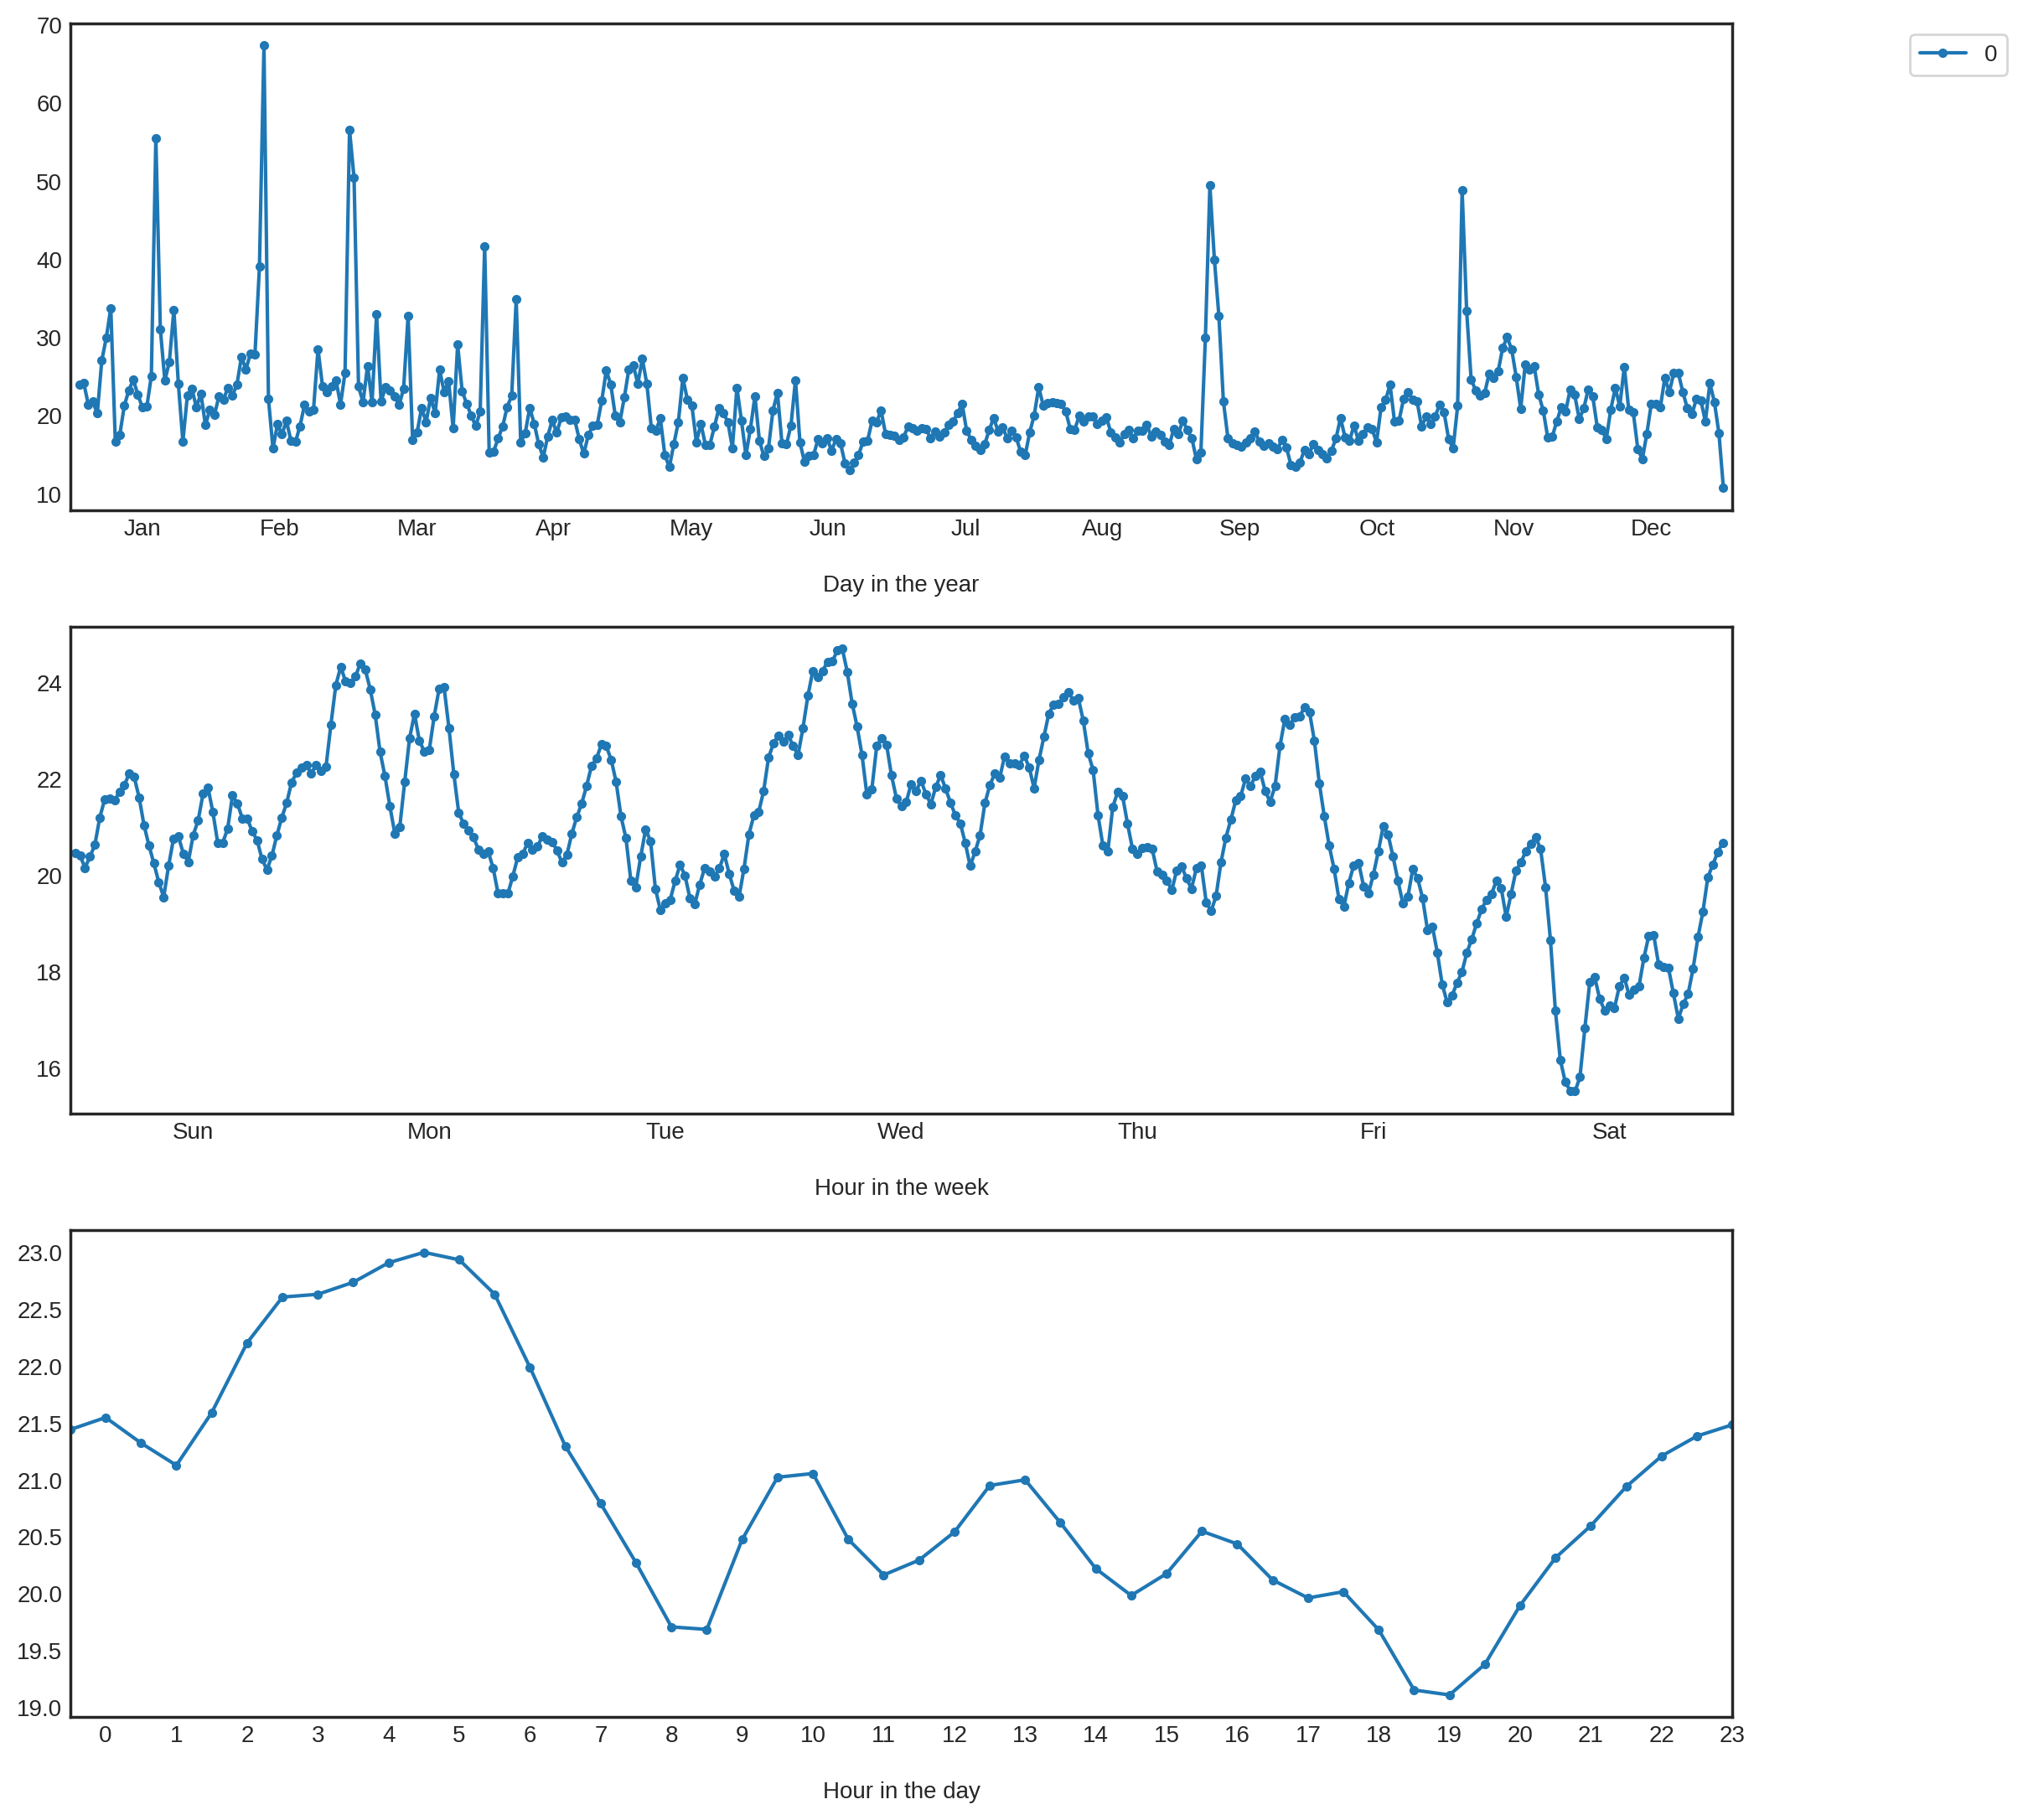

In [759]:
list_of_factors = temp_df.columns
plot_time_series_sections(temp_df,list_of_factors,times)

In [666]:
# Eventhough all these stations are transportation related, some have very differnt patterns - 
# like IRONID - maybe because of time when school ends. REMEZ is also a highschool.
# ATZMAUT_B is also similar. I believe that inside the city center you have another peak in 12-13 in addition to 
# morning and afternoon. 

In [ ]:
# Two questions - one - why is it that the highest values are in the night?
# two - could it be that all signals I see are in fact transportation, when each have different HUEMAN-related 
# transportation patterns?
# I keep thinking there is a problem here in the first place to assume this would work. One station can techniqly be 
# hald industry and half tranfic, or all stations could be very traffic related. 

In [ ]:
# TRY TO REMOVE TEMPERATURE influence (lapse rate?), wind, etc.. !!!
# For example - if PM2.5 is influenced by temperature(or other meteorological factors) and NOx isn't, then
# 1. I won't see a clear hourly transportation signal in PM2.5
# 2. I will look for a correlation with NOx but I won't find it. 

### Try to look at industry stations behaviour

In [830]:
temp_df=df[['KIRYAT_ATA','KIRYAT_BIALIK', 'KIRYAT_BINYAMIN', 'KIRYAT_TIVON','NESHER','ASHDOD_IGUD', 'ASHKELON_SOUTH']]

In [831]:
temp_df = pd.DataFrame(temp_df)
list_of_factors = temp_df.columns

In [832]:
temp_df

,KIRYAT_ATA,KIRYAT_BIALIK,KIRYAT_BINYAMIN,KIRYAT_TIVON,NESHER,ASHDOD_IGUD,ASHKELON_SOUTH
0,14.9,3.40,9.70,22.3,18.3,29.00,37.20
1,15.4,8.80,19.20,19.7,16.3,32.27,36.84
2,14.7,5.80,21.60,23.8,20.8,105.94,38.29
3,15.1,7.40,15.30,23.0,11.3,90.80,40.63
4,14.2,4.40,14.90,21.9,21.9,57.20,34.50
...,...,...,...,...,...,...,...
105161,35.4,22.38,29.10,31.8,24.3,20.20,16.90
105162,35.1,30.67,29.10,19.5,29.6,15.50,12.50
105163,33.4,19.21,32.50,24.3,26.2,20.70,13.46
105164,31.2,18.57,31.58,33.4,25.9,13.70,16.10


In [ ]:
plot_time_series_sections(temp_df,list_of_factors,times)

### Try to look at NOx behaviour

### Kipur day - is it only background+netural or includes industry as well? 

# Confirmatory FA 

In [ ]:
# https://buildmedia.readthedocs.org/media/pdf/factor-analyzer/latest/factor-analyzer.pdf

In [29]:
'''Confirmatory factor analysis (CFA), a closely associated technique, 
is used to test an a priori hypothesis about latent relationships among sets of 
observed variables. In CFA, the researcher specifies the expected pattern of factor 
loadings (and possibly other constraints), and fits a model according to this specification.'''

'Confirmatory factor analysis (CFA), a closely associated technique, is used to test an a priori hypothesis about latent relationships among sets of observed variables. In CFA, the researcher specifies the expected pattern of factor loadings (and possibly other constraints), and fits a model according to this specification.'

In [661]:
# A first guess would be to seperate "industrial stations" and "traffic stations"

In [722]:
model_dict = {"F1": ["IRONID", "KVISH4", "REMEZ", "YEFET_YAFO","ATZMAUT_B","BAR_ILAN","RAANANA"],
              "F2": ['KIRYAT_ATA',
                   'KIRYAT_BIALIK', 'KIRYAT_BINYAMIN', 'KIRYAT_TIVON',
                   'NESHER','ASHDOD_IGUD', 'ASHKELON_SOUTH']}
model_spec = ModelSpecificationParser.parse_model_specification_from_dict(df,model_dict)

In [723]:
cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=True, max_iter=5000)

In [724]:
import warnings
warnings.filterwarnings("default")

In [725]:
a = model_dict['F1']

In [726]:
a.extend(model_dict['F2'])

In [727]:
temp_df = df[a]

In [728]:
cfa.fit(temp_df.values)

/home/idit/.pyenv/versions/3.6.4/envs/global3.6.4/lib/python3.6/site-packages/scipy/optimize/lbfgsb.py:339: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/home/idit/.pyenv/versions/3.6.4/envs/global3.6.4/lib/python3.6/site-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.

/home/idit/.pyenv/versions/3.6.4/envs/global3.6.4/lib/python3.6/site-packages/factor_analyzer/confirmatory_factor_analyzer.py:733: UserWarning:

The optimization routine failed to converge: b'ABNORMAL_TERMINATION_IN_LNSRCH'



ConfirmatoryFactorAnalyzer(max_iter=5000, n_obs=105166,
                           specification=<factor_analyzer.confirmatory_factor_analyzer.ModelSpecification object at 0x7f1088569a20>)

In [729]:
cfa.loadings_

array([[23.77997525,  0.        ],
       [25.14098331,  0.        ],
       [30.38088566,  0.        ],
       [17.42317208,  0.        ],
       [15.57782543,  0.        ],
       [19.80840983,  0.        ],
       [19.51538185,  0.        ],
       [ 0.        , 28.25537941],
       [ 0.        , 25.63130681],
       [ 0.        , 19.83097494],
       [ 0.        , 19.22977281],
       [ 0.        , 22.52214071],
       [ 0.        , 21.74118268]])

In [730]:
cfa.factor_varcovs_

array([[1.        , 0.71647178],
       [0.71647178, 1.        ]])

In [731]:
cfa.get_standard_errors()

(array([[0.05601034, 0.        ],
        [0.05824157, 0.        ],
        [0.07009493, 0.        ],
        [0.04390623, 0.        ],
        [0.04106727, 0.        ],
        [0.05114797, 0.        ],
        [0.04747191, 0.        ],
        [0.        , 0.06507341],
        [0.        , 0.06012797],
        [0.        , 0.0486741 ],
        [0.        , 0.04655586],
        [0.        , 0.05436842],
        [0.        , 0.05303417]]),
 array([0.24552063, 0.22618605, 0.31394182, 0.23950085, 0.25677657,
        0.36535756, 0.22695424, 0.27195998, 0.27719474, 0.2550735 ,
        0.21325943, 0.28496669, 0.29113023]))

In [732]:
# cfa.get_model_implied_cov()

In [733]:
df_load = pd.DataFrame(cfa.loadings_,columns=['F1','F2'])
df_scores = pd.DataFrame(cfa.transform(temp_df.values), columns=['F1','F2'])

df_scores = add_group_columns_to_df_scores(df_scores,times)

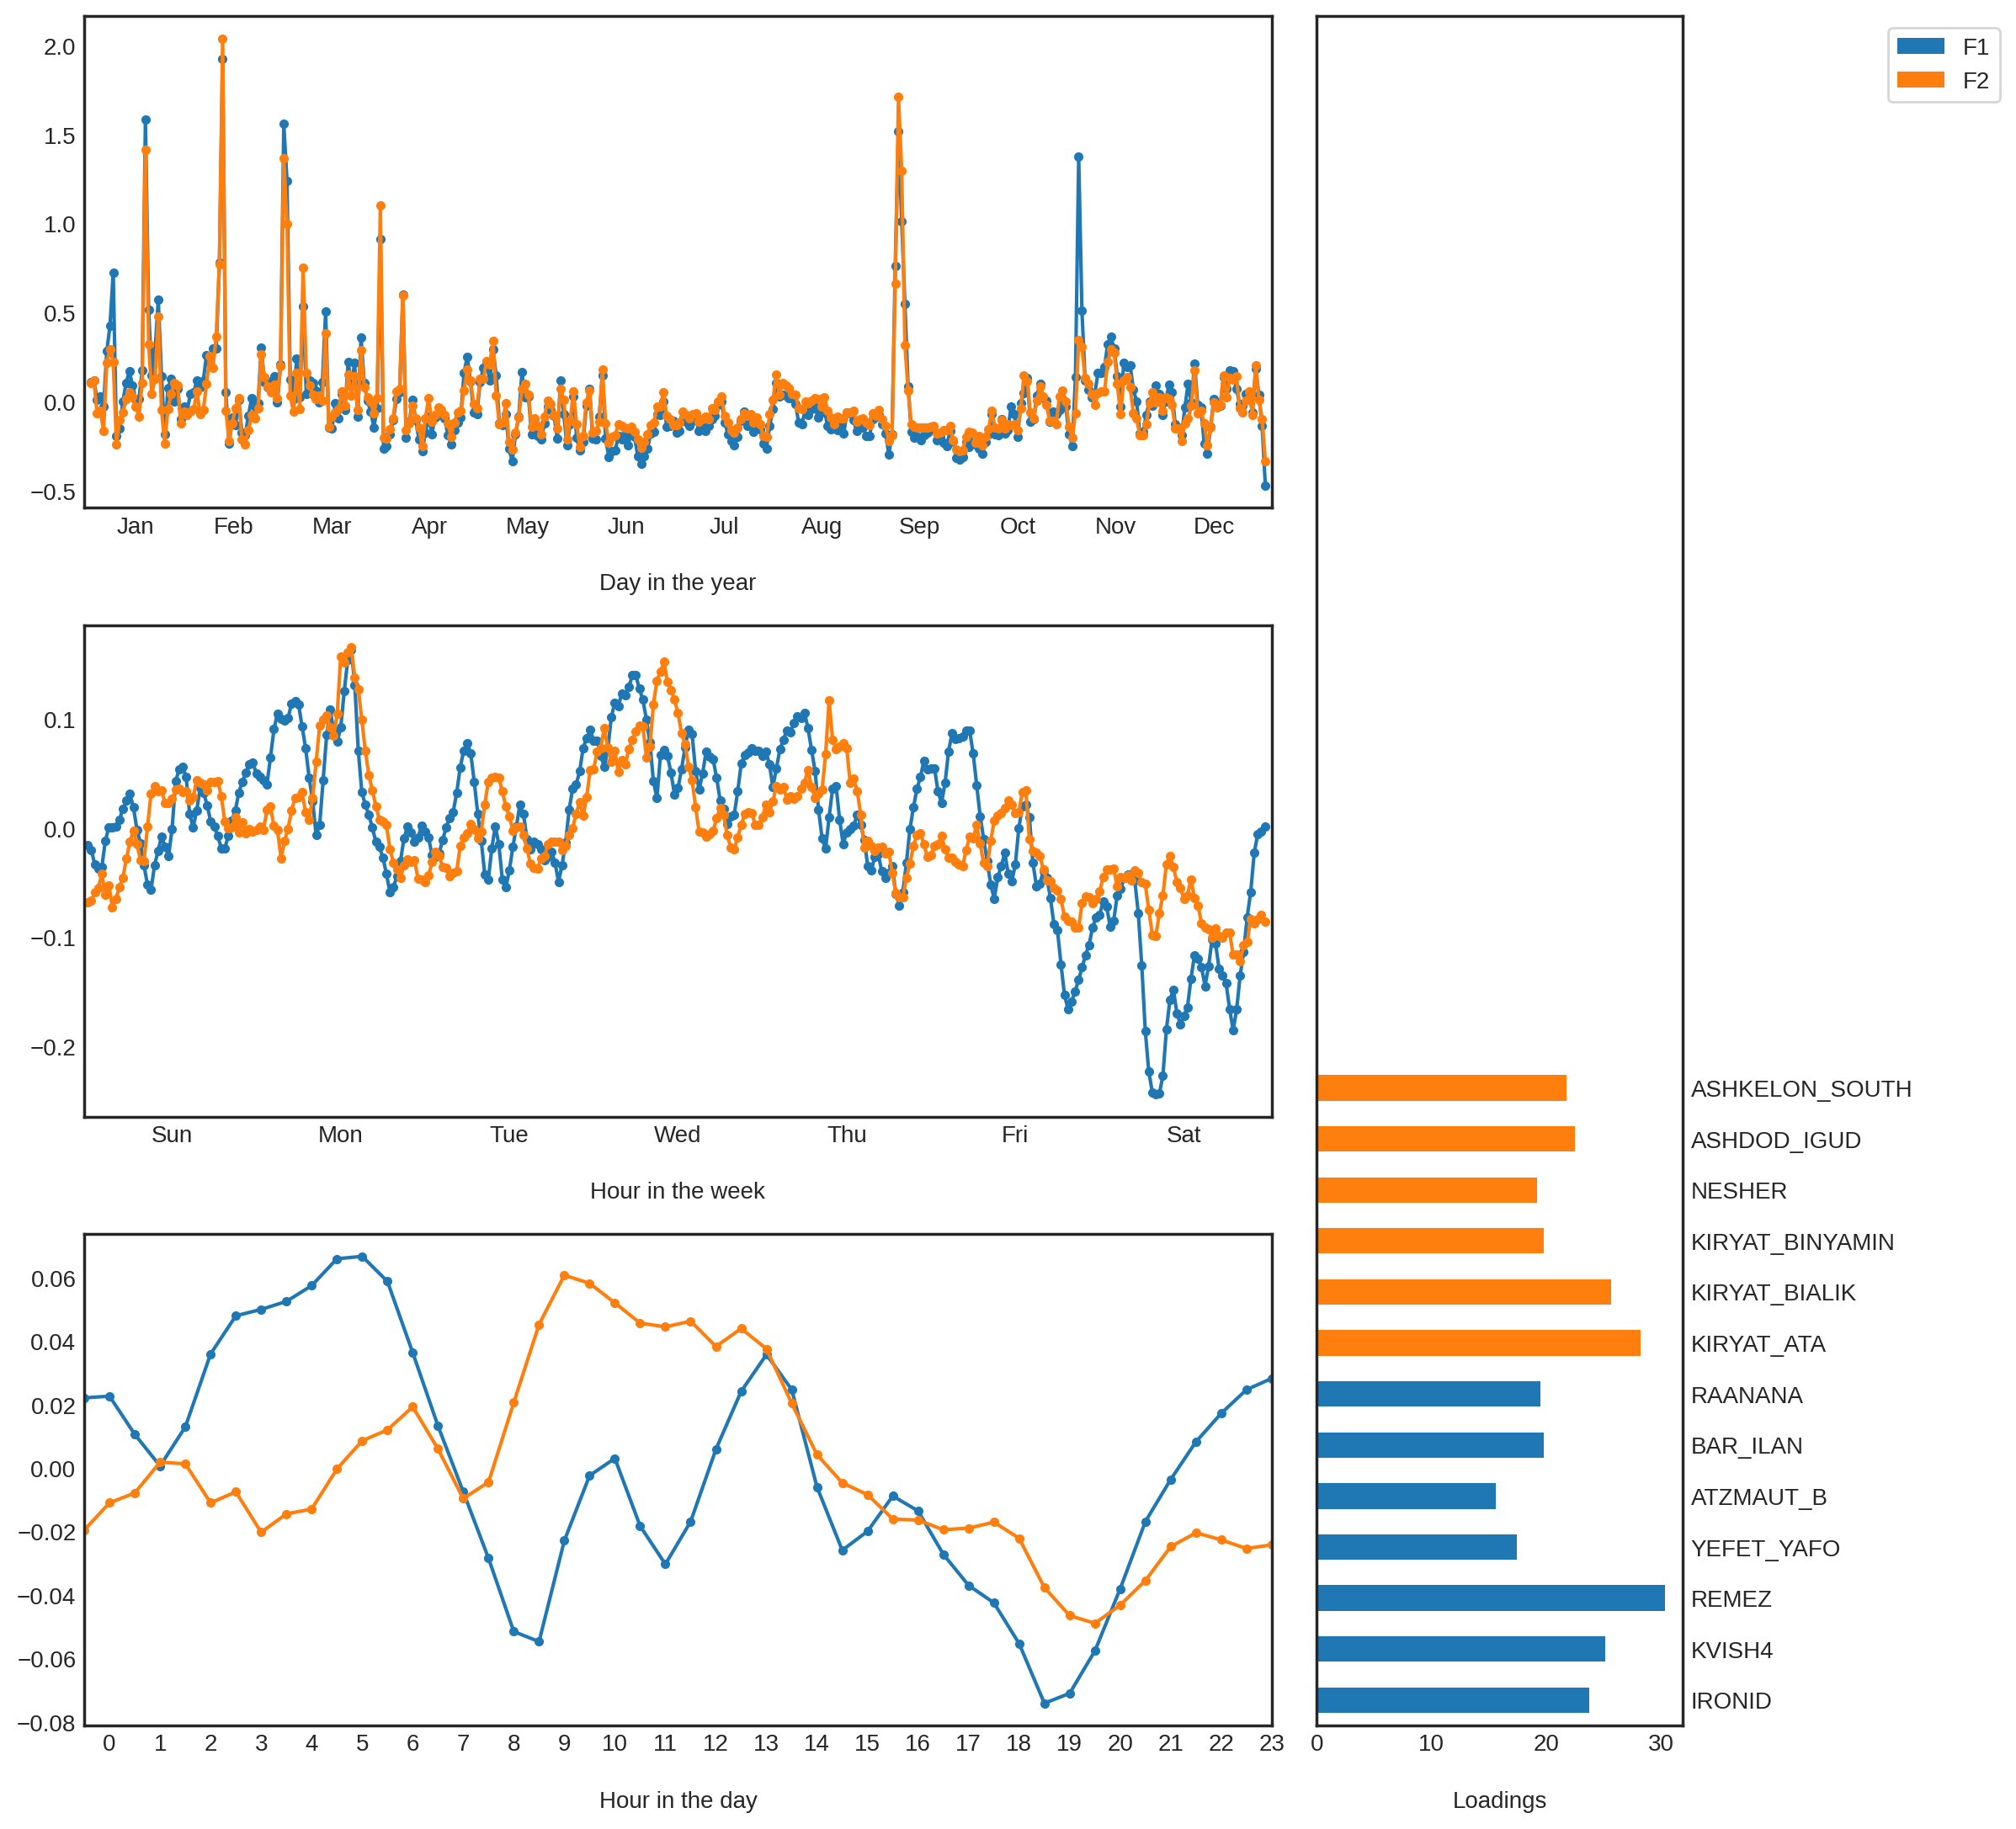

In [734]:
list_of_factors = ['F1','F2']
plot_factors_and_loadings(df_scores,df_load,list_of_factors, temp_df.columns)

# ICA

In [484]:
ica = FastICA(n_components=NUM)
S_ = ica.fit_transform(df)  # Reconstruct signals = factors
fa.loadings_ = ica.mixing_  # Get estimated mixing matrix = loadings


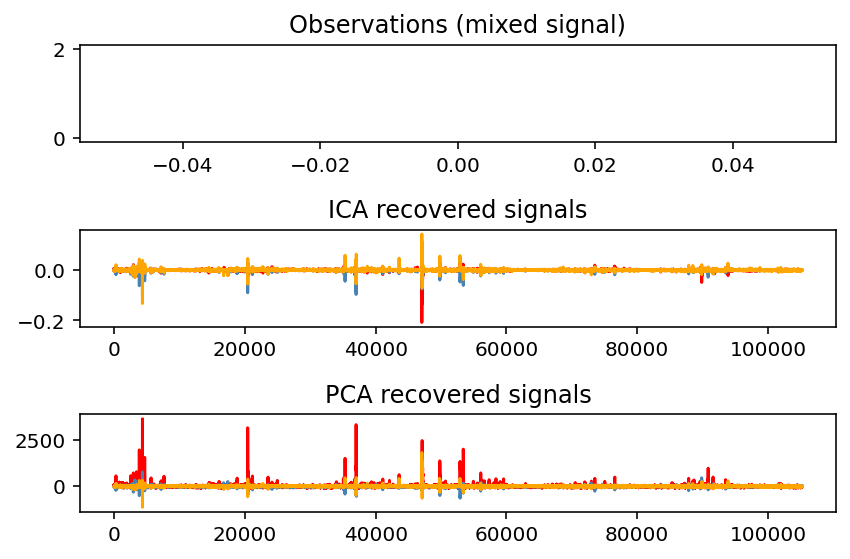

In [477]:
# #############################################################################
X = df.copy()
# S /= S.std(axis=0)  # Standardize data
# # Mix data
# A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
# X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals = factors
A_ = ica.mixing_  # Get estimated mixing matrix = loadings

# # We can `prove` that the ICA model applies by reverting the unmixing.
# assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

# #############################################################################
# Plot results

plt.figure()

models = [X, S_, H]
names = ['Observations (mixed signal)',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(3, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show();

In [483]:
A_

array([[-3986.49868082, -5229.02940946,   -24.63857135],
       [ -986.76038526, -6494.22005296,    97.36456816],
       [ -730.91228849, -6140.95687262,   135.21046555],
       [ -880.59684253, -6249.20661389,  -277.16016221],
       [ -994.67215702, -6583.48860923,    29.67112943],
       [ -618.58967733, -7213.45038378,   192.61819595],
       [-1035.0074852 , -7385.43947014,   376.58399746],
       [ -593.49255582, -4648.32868612,  -164.81165463],
       [-3961.42107674, -5996.32287051, -1244.68334866],
       [-2529.90511991, -4288.52294711, -1498.05501597],
       [-3236.17364162, -5986.3797002 , -2575.72989093],
       [-3792.89080573, -5186.03489218, -1758.84750258],
       [-2560.57528297, -4133.6409216 , -1791.58610279],
       [-2833.47915225, -4155.43581347, -1498.95403782],
       [-2536.23043986, -3929.32208708, -1494.33860939],
       [-2361.88427092, -3902.51111963, -1546.45358255],
       [-5701.55438543, -3834.96367359,  2964.53046169],
       [-4818.98138972, -4805.9

In [482]:
(np.dot(S_, A_.T) + ica.mean_).shape
X.shape

(105166, 34)

(105166, 34)

In [ ]:
# dynamic FA

# file:///Users/iditbela/Downloads/Dynamic_factor_analysis_to_estimate_common_trends_.pdf
# https://projecteuclid.org/download/pdf_1/euclid.ba/1340370408
# https://pure.au.dk/portal/files/104842477/PhD_dissertation_Jakob_G_Mikkelsen.pdf#page=18

# Trash

In [553]:
# geoplot.polyplot(gdf, figsize=(8, 4)) # this gives empty plot - is X and Y oposite? is it not centered?

# # one option - specify the projection - didn't work (something with centering)
# geoplot.polyplot(gdf, projection=gcrs.TransverseMercator(), figsize=(8, 4))

In [ ]:
# #1
# # fig, ax = plt.subplots(figsize=(8,4))
# df_scores.groupby(['Day in year'])['F1','F2','F3','F4'].mean().plot(style='.-',color=['c','m','#d9534f','#9ad801'])
# plt.xlim([-1,368])
# plt.xticks(np.linspace(15,365-15,12), ('Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov', 'Dec'))
# plt.xlabel('')


# #2
# # fig, ax = plt.subplots(figsize=(8,4))
# df_scores.groupby(['week day','hour','minute'])['F1','F2','F3','F4'].mean().plot(style='.-',color=['c','m','#d9534f','#9ad801'])
# plt.xlim([-1,48*7+1])
# plt.xticks(np.linspace(24,48*7-24,7), ('Sun', 'Mon','Tue','Wed','Thu','Fri','Sat'))
# plt.xlabel('')


# #3
# # fig, ax = plt.subplots(figsize=(8,4))
# df_scores.groupby(['hour','minute'])['F1','F2','F3','F4'].mean().plot(style='.-',color=['c','m','#d9534f','#9ad801'])
# plt.xlim([0,47])
# plt.xticks(np.linspace(1,48-1,24), [str(i) for i in range(24)])
# plt.xlabel('')
# plt.show();